In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/steam-reviews-2021/steam_reviews.csv
/kaggle/input/how-to-get-32gb-ram/train_labels.parquet
/kaggle/input/how-to-get-32gb-ram/__results__.html
/kaggle/input/how-to-get-32gb-ram/train.parquet
/kaggle/input/how-to-get-32gb-ram/submission.csv
/kaggle/input/how-to-get-32gb-ram/__notebook__.ipynb
/kaggle/input/how-to-get-32gb-ram/__output__.json
/kaggle/input/how-to-get-32gb-ram/custom.css


# Packages

In [3]:
# Required packages installation
!pip install nltk pywaffle highlight_text huggingface_hub transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 65.1 MB/s eta 0:00:00:00:0100:01


In [4]:
# Required package import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import kagglehub
from huggingface_hub import hf_hub_download
import transformers
from pywaffle import Waffle
import plotly.graph_objs as go
from sklearn.impute import SimpleImputer
import plotly.graph_objects as go
from scipy import stats
import matplotlib.ticker as mticker
from datetime import datetime
from scipy.stats import f_oneway
import squarify
from transformers import pipeline
import torch
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import plotly.express as px

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [5]:
# Download the CSV file
path = kagglehub.dataset_download("najzeko/steam-reviews-2021")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/steam-reviews-2021


In [6]:
# Define the path in which we saved the CSV file
dataset_path = os.path.join(path, 'steam_reviews.csv')

#Import the CSV file as a pandas DataFrame
df = pd.read_csv(dataset_path, header='infer', index_col=0)

# RQ1. EDA
**Steam** is one of the largest digital distribution platforms for PC games, offering a vast library of titles across genres and from developers worldwide. Steam allows users to purchase, download, and manage games, while also providing a range of features for community engagement, such as player reviews, achievements, and social interactions. In addition to its primary function as a storefront, Steam also serves as a social hub, where users can review games, share experiences, and connect with other players. Reviews, in particular, are crucial to Steam’s ecosystem, offering insights for other players and feedback for developers.

The dataset we are analyzing focuses specifically on game reviews posted on Steam, capturing extensive information about both the games and the reviewers themselves. This platform provides a comprehensive library of PC games, catering to millions of users who frequently leave feedback on their gameplay experiences.

This dataset collects detailed information about each author, including attributes like the reviewer’s unique identification number, the total number of games they own, the number of reviews they have written, the hours they have played the game they are reviewing, and their total hours played across all games owned. It also includes information about the games themselves, such as the game’s name, unique identification number, and whether it was purchased on Steam or received for free.

The most critical data, however, pertains to the review itself, including details like: the unique identification number of the review,the language in which it was written, the review’s text content, the date it was written or last updated, whether the review was posted during the game’s early access phase.
Furthermore, the dataset captures aspects of the reviewer’s opinion and the engagement from other users, including whether they recommended the game, whether the review was found funny or helpful, and the number of comments it received.

In the following sections, we will conduct an exploratory data analysis (EDA) to understand the dataset’s structure and identify key insights. This process includes examining the basic distribution of variables, checking data types, analyzing the dataset size, establishing a preprocessing pipeline (including the imputation of missing values), calculating statistical measures, and studying correlations between variables. This exploration will allow us to structure our analysis effectively and guide us in extracting meaningful insights from the dataset.

Here's a short description about the content of all the columns of the dataset, as a result of a better knowledge of the data.
It's important to understand what we are going to face during the analysis for the goal to find relationship between different variables.



1.   app_id: Unique identifier code for the game.
2.   app_name: Name of the game being reviewed.
3.   review_id: Unique identifier for the review.
4.   language: Language used in the review.
5.   review: Text content of the review.
6.   timestamp_created: Date and time when the review was created.
7.   timestamp_updated: Date and time when the review was last updated.
8.   recommended: Flag indicating whether the reviewer recommends the game.
9.   votes_helpful: Number of users who found the review helpful.
10.  votes_funny: Number of users who found the review funny.
11.  weighted_vote_score: Weighted score of the review based on helpful and funny votes received.
12.  comment_count: Number of comments received on the review.
13.  steam_purchase: Indicates if the game was purchased by the reviewer on Steam.
14.  received_for_free: Indicates if the reviewer received the game for free.
15.  written_during_early_access: Indicates if the review was written during the game’s early access period (before official release).
16.  author.steamid: Steam ID of the reviewer.
17.  author.num_games_owned: Total number of games owned by the reviewer.
18.  author.num_reviews: Total number of reviews written by the reviewer.
19.  author.playtime_forever: Total time in seconds the reviewer has spent playing the reviewed game on Steam.
20.  author.playtime_last_two_weeks: Total time in seconds the reviewer has spent playing the reviewed game in the last two weeks.
21.  author.playtime_at_review: Total time in seconds spent playing the specific game being reviewed at the time of the review.
22.  author.last_played: Date and time of the reviewer’s last gameplay session.

Let's look at the *dtype* of the variables.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21747371 entries, 0 to 21747375
Data columns (total 22 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   app_id                          int64  
 1   app_name                        object 
 2   review_id                       int64  
 3   language                        object 
 4   review                          object 
 5   timestamp_created               int64  
 6   timestamp_updated               int64  
 7   recommended                     bool   
 8   votes_helpful                   int64  
 9   votes_funny                     int64  
 10  weighted_vote_score             float64
 11  comment_count                   int64  
 12  steam_purchase                  bool   
 13  received_for_free               bool   
 14  written_during_early_access     bool   
 15  author.steamid                  int64  
 16  author.num_games_owned          int64  
 17  author.num_reviews            

As we can see from the output above, there are three columns where the data type is int (**timestamp_created, timestamp_updated, author.last_played**), although they represent time data. We will convert these columns to a DateTime format.

In [7]:
# Convert in datetime
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], unit='s')
df['timestamp_updated'] = pd.to_datetime(df['timestamp_updated'], unit='s')
df['author.last_played'] = pd.to_datetime(df['author.last_played'], unit='s')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21747371 entries, 0 to 21747375
Data columns (total 22 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   app_id                          int64         
 1   app_name                        object        
 2   review_id                       int64         
 3   language                        object        
 4   review                          object        
 5   timestamp_created               datetime64[ns]
 6   timestamp_updated               datetime64[ns]
 7   recommended                     bool          
 8   votes_helpful                   int64         
 9   votes_funny                     int64         
 10  weighted_vote_score             float64       
 11  comment_count                   int64         
 12  steam_purchase                  bool          
 13  received_for_free               bool          
 14  written_during_early_access     bool          
 15  a

In [12]:
df.head()

,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,...,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
0,292030,The Witcher 3: Wild Hunt,85185598,schinese,不玩此生遗憾，RPG游戏里的天花板，太吸引人了,2021-01-23 06:00:29,2021-01-23 06:00:29,True,0,0,...,True,False,False,76561199095369542,6,2,1909.0,1448.0,1909.0,2021-01-22 19:23:03
1,292030,The Witcher 3: Wild Hunt,85185250,schinese,拔DIAO无情打桩机--杰洛特!!!,2021-01-23 05:50:30,2021-01-23 05:50:30,True,0,0,...,True,False,False,76561198949504115,30,10,2764.0,2743.0,2674.0,2021-01-23 07:18:27
2,292030,The Witcher 3: Wild Hunt,85185111,schinese,巫师3NB,2021-01-23 05:46:40,2021-01-23 05:46:40,True,0,0,...,True,False,False,76561199090098988,5,1,1061.0,1061.0,1060.0,2021-01-23 06:36:17
3,292030,The Witcher 3: Wild Hunt,85184605,english,"One of the best RPG's of all time, worthy of a...",2021-01-23 05:32:50,2021-01-23 05:32:50,True,0,0,...,True,False,False,76561199054755373,5,3,5587.0,3200.0,5524.0,2021-01-23 06:35:44
4,292030,The Witcher 3: Wild Hunt,85184287,schinese,大作,2021-01-23 05:23:47,2021-01-23 05:23:47,True,0,0,...,True,False,False,76561199028326951,7,4,217.0,42.0,217.0,2021-01-16 09:10:49


In [13]:
df.shape

(21747371, 22)


Our dataset contains 21,747,371 rows in which 22 variables were observed.

In [15]:
df.describe().drop(columns=['app_id', 'review_id', 'author.steamid'])

,timestamp_created,timestamp_updated,votes_helpful,votes_funny,weighted_vote_score,comment_count,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
count,21747371,21747371,2.174737e+07,2.174737e+07,2.174737e+07,2.174737e+07,2.174737e+07,2.174737e+07,2.174737e+07,2.174737e+07,2.172169e+07,21747369
mean,2018-12-10 09:01:13.640280320,2019-01-15 12:34:24.105696768,4.044689e+05,1.267917e+05,1.654424e-01,1.308768e-01,1.011300e+06,4.044775e+05,1.609105e+04,1.555421e+02,8.807421e+03,2020-01-31 21:11:02.058051840
min,2010-11-19 20:17:16,2010-11-19 20:17:16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1970-01-01 00:00:00
25%,2017-11-09 10:19:31,2017-11-26 20:51:30,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.200000e+01,2.000000e+00,1.250000e+03,0.000000e+00,5.590000e+02,2019-11-09 19:57:56
50%,2019-07-06 20:52:52,2019-10-27 15:03:14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.100000e+01,4.000000e+00,4.307000e+03,0.000000e+00,1.881000e+03,2020-09-02 14:47:10
75%,2020-05-17 06:14:08.500000,2020-06-06 00:21:27.500000,1.000000e+00,0.000000e+00,4.827586e-01,0.000000e+00,1.450000e+02,1.000000e+01,1.491200e+04,0.000000e+00,6.823000e+03,2020-12-26 17:03:29
max,2021-01-23 18:24:47,2042-05-11 00:59:57,4.398047e+12,4.294967e+09,9.959868e-01,4.893000e+03,4.398047e+12,4.398047e+12,3.744943e+06,2.703900e+04,3.228103e+06,2021-01-23 20:35:42
std,NaN,NaN,1.333741e+09,2.333553e+07,2.434006e-01,2.199398e+00,2.108829e+09,1.333741e+09,3.743057e+04,7.300488e+02,2.388553e+04,NaN


As we can observe by the statistics above first of all we can notice that the data has been collected between 2010 and 2021. It also seems weird that for some column the max value is surely out of range, for example if we look at the columns: votes_helpful, votes_funny, author.num_games_owned, author.num_reviews there is a max value of 4.398047e+12.
So is interesting to explore the presence of outliers and NaN values, as you can find in the next lines.
It's interesting that the max value of 4.398047e+12 is very close to $2^{42}$ and also the max value of the *votes_funny* column is so close to $2^{32}$. These values were probably caused by errors in the data gathering process.
It also interesting to notice that all thes values are coming from variables with an int64 dtype.

### Outliers Pre-Processing

We check how many values in the *timestamp_updated* column report dates after 2021 (the year the dataset was made).

In [16]:
df[df['timestamp_updated'].dt.year > 2021]

,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,...,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
3538179,311690,Enter the Gungeon,84438558,latam,Ta bueno.. pero la música es horripilante a ni...,2021-01-10 16:24:18,2042-05-11 00:59:57,False,0,0,...,False,False,False,76561198049701040,456,132,41.0,0.0,41.0,2020-06-28 00:13:08
9287506,203160,Tomb Raider,18314506,english,"Brutal and gritty as fuck, the story is beyond...",2015-10-03 21:04:05,2037-02-03 21:05:26,True,1,0,...,True,False,False,76561198069242328,634,10,578.0,0.0,568.0,2018-07-10 22:02:23
10694935,526870,Satisfactory,70510346,german,Dieses Spiel ist Deluxe !\n\nNoch in der Early...,2020-06-08 22:47:04,2042-03-25 18:57:27,True,19,0,...,True,False,True,76561197966082036,234,45,6255.0,486.0,103.0,2021-01-19 00:57:12
14636770,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,43243949,russian,💕,2018-07-02 13:25:41,2040-08-05 09:33:57,True,12,2,...,False,False,False,76561198116664064,649,16,56860.0,0.0,17108.0,2020-12-17 12:55:13


In [8]:
df = df[df['timestamp_updated'].dt.year <= 2021]

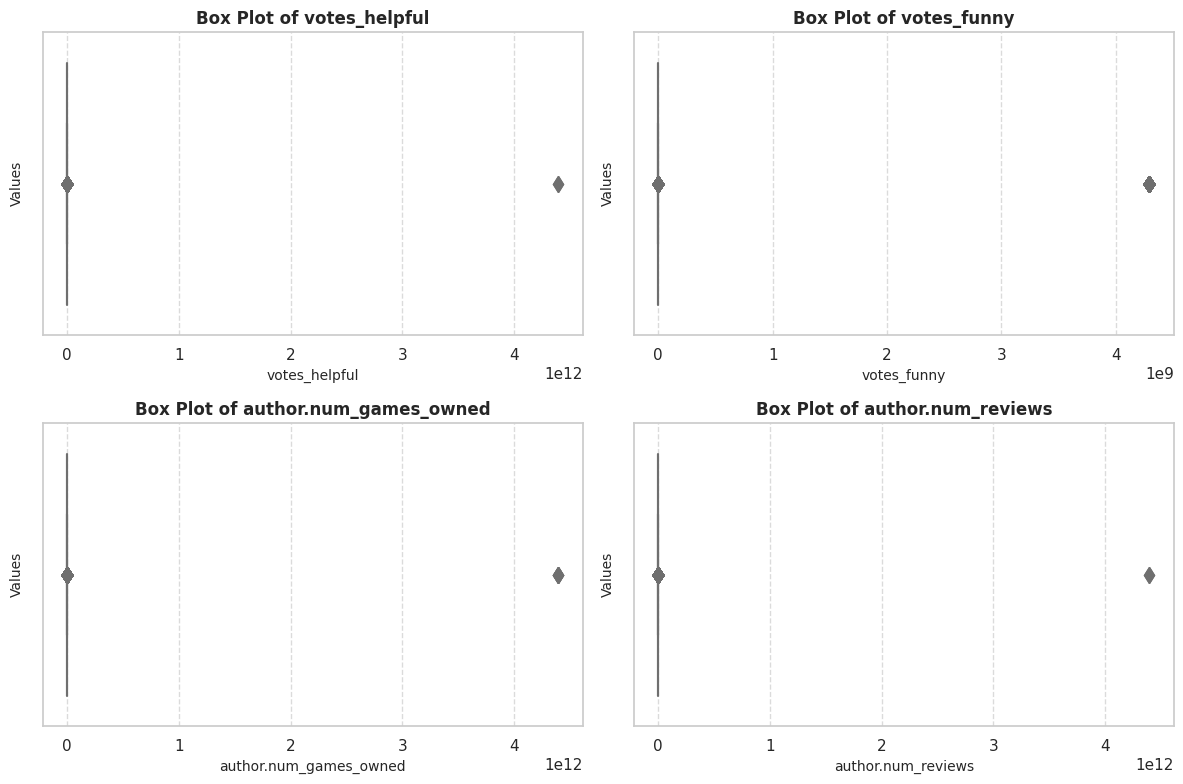

In [13]:
numerical_vars = ['votes_helpful', 'votes_funny', 'author.num_games_owned', 'author.num_reviews']
sns.set(style="whitegrid")

# Set up the 2x2 figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# BoxPlot for each variable
for i, var in enumerate(numerical_vars):
    sns.boxplot(x=df[var], ax=axes[i], color='skyblue', fliersize=8, linewidth=1.5)
    axes[i].set_title(f'Box Plot of {var}', fontsize=12, weight='bold')
    axes[i].set_xlabel(var, fontsize=10)
    axes[i].set_ylabel('Values', fontsize=10)
    axes[i].grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In the next few code blocks, we are checking outlier values for the columns that had extreme max values described above, and well defined outliers in the plot above. We will impute the median into these outliers because it's not affected by them, unlike the mean.

In [18]:
df[df['author.num_games_owned'] > 1000000]

,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,...,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
3507698,40800,Super Meat Boy,30793110,schinese,痛并快乐着,2017-03-28 13:37:34,2017-03-28 13:37:34,True,0,0,...,True,False,False,76561198242864522,4398046511179,7,298.0,0.0,298.0,2017-04-01 13:17:33
5502450,1158310,Crusader Kings III,80957958,english,noice,2020-11-28 23:24:51,2020-11-28 23:24:51,True,0,0,...,False,False,False,76561198039421205,4398046511619,5,2728.0,546.0,2157.0,2021-01-06 20:46:17
6913010,945360,Among Us,77941131,english,"Without a doubt, one of the best 2020 games. T...",2020-10-21 22:04:00,2020-10-21 22:04:00,True,0,0,...,True,False,False,76561198127787009,4398046511151,19,2394.0,0.0,1117.0,2020-12-17 16:18:24
8680946,48700,Mount & Blade: Warband,21886177,english,10/10 Simple yet fucking amazing,2016-03-17 13:39:04,2016-03-17 13:39:04,True,1,0,...,True,False,False,76561198070649181,4398046511170,5,19825.0,0.0,11630.0,2020-02-20 22:28:29
21079026,236850,Europa Universalis IV,72770077,russian,"Наиграв почти 50 часов, я решил сделать обзор....",2020-07-16 05:45:36,2020-07-16 05:45:36,True,1,0,...,True,False,False,76561198148961412,4398046511316,12,3177.0,0.0,2776.0,2020-07-20 19:21:02


In [9]:
median_num_games_owned = df['author.num_games_owned'].median()
df.loc[df['author.num_games_owned'] > 1000000, 'author.num_games_owned'] = median_num_games_owned

In [20]:
df[df['author.num_reviews'] > 1000000]

,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,...,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
5663042,413150,Stardew Valley,61995164,english,I think my favorite part of this game is the m...,2020-01-17 20:31:55,2020-01-17 20:31:55,True,0,0,...,True,False,False,76561198848008157,45,4398046511105,1505.0,0.0,1306.0,2020-06-20 02:16:00
13093698,271590,Grand Theft Auto V,62108069,latam,wen juego alv,2020-01-19 21:39:05,2020-01-19 21:39:05,True,0,0,...,True,False,False,76561198103272004,40,4398046511108,17966.0,0.0,1689.0,2020-12-24 23:17:20


In [10]:
median_num_reviews = df['author.num_reviews'].median()
df.loc[df['author.num_reviews'] > 1000000, 'author.num_reviews'] = median_num_reviews

In [22]:
df[df['votes_funny'] > 1000000]

,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,...,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
376209,292030,The Witcher 3: Wild Hunt,32891513,english,One of the best gaming experiences you will ev...,2017-06-27 21:47:27,2017-06-27 21:47:27,True,1,4294967295,...,True,False,False,76561197980195272,280,10,14038.0,0.0,11867.0,2019-09-03 02:19:14
376337,292030,The Witcher 3: Wild Hunt,32868864,brazilian,SHOW,2017-06-27 17:46:20,2017-06-27 17:46:20,True,2,4294967295,...,True,False,False,76561198001002561,59,8,7340.0,0.0,4652.0,2018-12-15 22:07:30
377919,292030,The Witcher 3: Wild Hunt,32552529,english,BBBBBBBBBBBBBBBBOOOOOOOOOOOOOOBBBBBBBBBBBBBBBB...,2017-06-18 23:27:01,2017-06-18 23:27:01,True,1,4294967295,...,True,False,False,76561198240855902,63,9,38888.0,26.0,6211.0,2021-01-20 02:21:45
378093,292030,The Witcher 3: Wild Hunt,32504988,schinese,业界标杆,2017-06-17 13:44:46,2017-06-17 13:44:46,True,2,4294967295,...,True,False,False,76561198177321830,3402,109,10161.0,0.0,9451.0,2020-04-03 18:00:22
380428,292030,The Witcher 3: Wild Hunt,32101630,schinese,对我来说超越游戏的存在，我的老朋友,2017-06-01 07:03:24,2017-06-01 07:03:24,True,2,4294967292,...,True,False,False,76561198283661028,34,3,9752.0,0.0,6526.0,2017-08-17 11:07:33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21644981,512900,Streets of Rogue,30497611,english,Played through the free weekend solo and a gro...,2017-03-13 21:32:07,2017-03-13 21:32:07,True,1,4294967295,...,True,False,True,76561197990240688,336,2,1227.0,0.0,567.0,2018-01-06 23:35:53
21647898,357190,Ultimate Marvel vs. Capcom 3,31288580,english,I like the game and I had a big gripe when I f...,2017-04-22 04:09:54,2017-04-22 15:55:24,True,0,4294967295,...,True,False,False,76561198067809939,431,12,29.0,0.0,29.0,2017-04-22 04:35:29
21653299,569860,Thimbleweed Park,32656907,english,A refreshing throwback to adventure games of o...,2017-06-22 23:47:53,2017-06-22 23:47:53,True,1,4294967295,...,True,False,False,76561197970338561,562,1,1558.0,0.0,1558.0,2017-04-12 23:15:50
21684719,572410,Steel Division: Normandy 44,31216356,schinese,现在的beta只有3幅地图和4个师，所以只能做一个非常有限的评测。\n \n ...,2017-04-18 11:10:34,2017-04-18 11:30:07,True,19,4294967295,...,True,False,False,76561198054197421,312,15,20921.0,0.0,5485.0,2021-01-01 09:35:02


In [11]:
median_votes_funny = df['votes_funny'].median()
df.loc[df['votes_funny'] > 1000000, 'votes_funny'] = median_votes_funny

In [24]:
df[df['votes_helpful'] > 1000000]

,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,...,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
10449394,274190,Broforce,23973728,brazilian,"Jogo muito bom. Recomendo ele, vale cada centa...",2016-07-01 03:33:12,2016-07-01 03:33:12,True,4398046511104,0,...,True,False,False,76561198315745673,100,2,337.0,0.0,228.0,2016-07-04 03:02:00
10751986,960090,Bloons TD 6,63684360,english,"I don't know what to say, but just to go pop s...",2020-02-17 19:08:27,2020-02-17 19:08:27,True,4398046511106,1,...,True,False,False,76561198049020554,3524,322,1658.0,0.0,1535.0,2020-03-25 01:44:37


In [12]:
median_votes_helpful = df['votes_helpful'].median()
df.loc[df['votes_helpful'] > 1000000, 'votes_helpful'] = median_votes_helpful

### NaN Values Pre-Processing

As a part of the exploration of data phase we investigate for the existence of NaN values. To do this we check for every column the number of NaN values in it.

In [27]:
# Check the number of NaN values for each column
for col in df.columns:
  na_values = df[col].isna().sum()
  print(f'{na_values} NaN values in the {col} column')

0 NaN values in the app_id column
0 NaN values in the app_name column
0 NaN values in the review_id column
0 NaN values in the language column
33748 NaN values in the review column
0 NaN values in the timestamp_created column
0 NaN values in the timestamp_updated column
0 NaN values in the recommended column
0 NaN values in the votes_helpful column
0 NaN values in the votes_funny column
0 NaN values in the weighted_vote_score column
0 NaN values in the comment_count column
0 NaN values in the steam_purchase column
0 NaN values in the received_for_free column
0 NaN values in the written_during_early_access column
0 NaN values in the author.steamid column
0 NaN values in the author.num_games_owned column
0 NaN values in the author.num_reviews column
2 NaN values in the author.playtime_forever column
2 NaN values in the author.playtime_last_two_weeks column
25682 NaN values in the author.playtime_at_review column
2 NaN values in the author.last_played column


Since we have 25682 rows with NaN values in the *author.playtime_at_review* column we impute it with the mean of that column.

In [18]:
# Using the sklearn imputer, replacing NaN values with mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X = df[['author.playtime_at_review']]
X_imputed = imp.fit_transform(X)
df['author.playtime_at_review'] = X_imputed

Since there are only two rows with NaN values in the *author.playtime_forever*, *author.last_played*, and *author.playtime_last_two_weeks* columns, we will drop these rows.

In [19]:
# Drop rows where there are NaN values in the specified columns
df = df.dropna(subset=['author.playtime_forever', 'author.last_played', 'author.playtime_last_two_weeks'])

In [20]:
# Check the result
print(df.isna().sum())

app_id                                0
app_name                              0
review_id                             0
language                              0
review                            33748
timestamp_created                     0
timestamp_updated                     0
recommended                           0
votes_helpful                         0
votes_funny                           0
weighted_vote_score                   0
comment_count                         0
steam_purchase                        0
received_for_free                     0
written_during_early_access           0
author.steamid                        0
author.num_games_owned                0
author.num_reviews                    0
author.playtime_forever               0
author.playtime_last_two_weeks        0
author.playtime_at_review             0
author.last_played                    0
dtype: int64


We chose to leave reviews without textual content as null values, to avoid altering the informational content by inserting blank text or losing information by deleting the corresponding rows. However, during the analysis, where necessary, these null values will be imputed without altering the dataset structure.

### Plot of meaningful variables

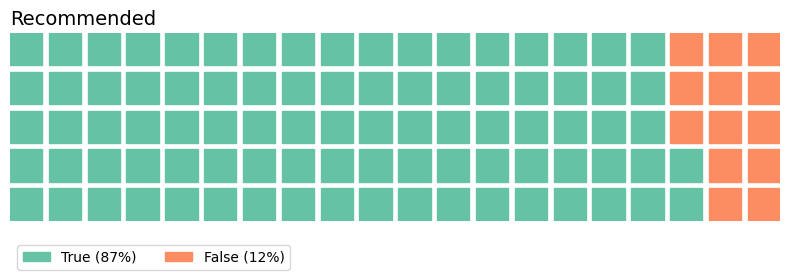

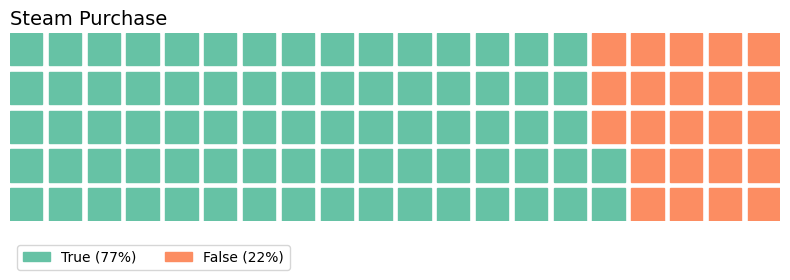

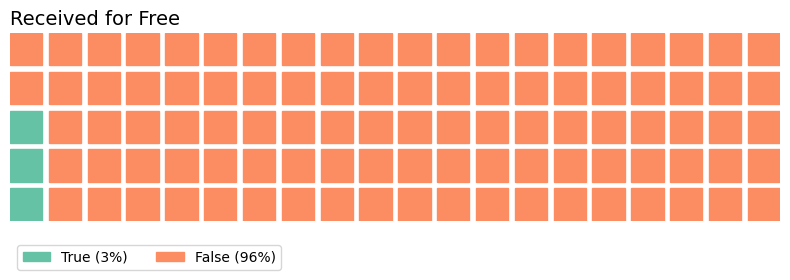

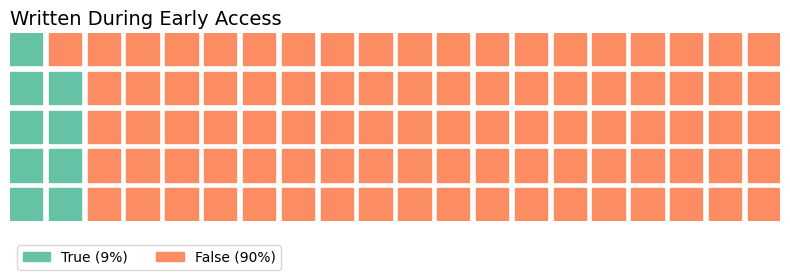

In [31]:
boolean_vars = ['recommended', 'steam_purchase', 'received_for_free', 'written_during_early_access']
titles = ['Recommended', 'Steam Purchase', 'Received for Free', 'Written During Early Access']

for i, var in enumerate(boolean_vars):
    df[var] = df[var].astype(bool)
    
    # Calculate the distribution between True and False values
    counts = df[var].value_counts()
    data = {'True': counts.get(True, 0), 'False': counts.get(False, 0)}
    repartition = [f"{k} ({int(v / sum(data.values()) * 100)}%)" for k, v in data.items()]
    
    # Waffle Chart for each variable
    fig = plt.figure(
        FigureClass=Waffle,
        rows=5,
        columns=20,
        values=data,
        title={
            'label': titles[i],
            'loc': 'left',
            'fontsize': 14
        },
        labels=repartition,
        legend={
            'loc': 'lower left',
            'bbox_to_anchor': (0, -0.3),
            'ncol': len(data),
            'fontsize': 10
        },
        figsize=(8, 6)
    )
    plt.show()

Socially speaking, people tend to complain and find faults in things, especially when they buy them. So, despite expectations, most people actually recommend the games.

We can observe that there isn’t a direct correlation between purchased games and those received for free. In other words, we can’t assume that if a game wasn’t purchased on Steam, it was received for free; it’s possible it was bought outside the platform. In fact, only a very small percentage of users received the game for free, likely due to temporary offers, while the majority of users typically purchase the game directly on the platform.

Finally, it is interesting to note that a small percentage of people write reviews before the official release of the game. This indicates that there is a part of the Steam community which is highly passionate about the games they review.

In [32]:
# Number of reviews per month
monthly_reviews = df.groupby(df['timestamp_created'].dt.to_period('M')).size().reset_index(name='review_count')

# Convert the 'timestamp_created' column back to a timestamp format
monthly_reviews['timestamp_created'] = monthly_reviews['timestamp_created'].dt.to_timestamp()
frames = [
    go.Frame(
        data=[
            go.Scatter(
                x=monthly_reviews['timestamp_created'][:i+1],
                y=monthly_reviews['review_count'][:i+1],
                mode='lines+markers',
                line=dict(color='#d90429', width=3),
                marker=dict(size=6)
            )
        ],
        name=str(i)
    ) for i in range(1, len(monthly_reviews))
]

# Initial plot setup
fig = go.Figure(
    data=[
        go.Scatter(
            x=[monthly_reviews['timestamp_created'].iloc[0]],  # Start with the first timestamp
            y=[monthly_reviews['review_count'].iloc[0]],  # Start with the first review count
            mode='lines+markers',
            line=dict(color='#d90429', width=3),
            marker=dict(size=6)
        )
    ],
    layout=go.Layout(
        title=dict(
            text="Monthly Reviews Over Time",
            font=dict(size=20, color='#fefae0'),
            x=0.5,
            y=0.9
        ),
        xaxis=dict(
            title="Date",
            showgrid=False,
            color='#fefae0'
        ),
        yaxis=dict(
            title="Review Count",
            color='#fefae0',
            showgrid=False,
            range=[0, monthly_reviews['review_count'].max() * 1.1]
        ),
        plot_bgcolor='#0d1b2a',
        paper_bgcolor='#0d1b2a',
        font=dict(color='#fefae0'),
        updatemenus=[
            dict(
                type="buttons",
                showactive=False,
                buttons=[dict(label="Play", method="animate", args=[None, dict(frame=dict(duration=200, redraw=True), fromcurrent=True)])]
            )
        ]
    ),
    frames=frames  # Add the frames for the animation
)

# Add play button and frame settings for animation
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            showactive=False,
            x=0.1, y=-0.15,
            xanchor="right",
            yanchor="top",
            buttons=[
                dict(
                    label="Play",
                    method="animate",
                    args=[
                        None, 
                        dict(
                            frame=dict(duration=200, redraw=True),
                            fromcurrent=True
                        )
                    ]
                ),
                dict(
                    label="Pause",
                    method="animate",
                    args=[
                        [None], 
                        dict(frame=dict(duration=0, redraw=False), mode="immediate", fromcurrent=True)
                    ]
                )
            ]
        )
    ]
)
fig.show()

# Source: https://python-graph-gallery.com/

The plot reveals a noticeable seasonality, with recurrent spikes in November starting from 2016. This trend could be due to the timing of game releases, as many games typically launch in September and October, which then drives reviews in the following months. These November spikes also grow each year, possibly influenced by the COVID-19 pandemic, which increased gaming activity as people spent more time at home.

Additionally, we can see that from 2010 to 2013, the number of reviews was quite low, with a significant rise beginning in December 2013. This uptick aligns with the release of the PlayStation 4 and Xbox One in November 2013, which likely contributed to a surge in gaming activity and an increase in game reviews across platforms, including PC.

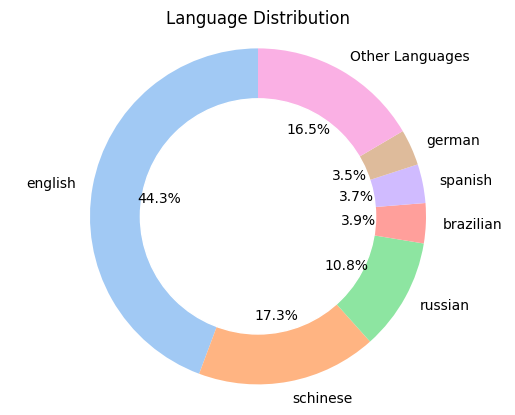

In [33]:
# Set the threshold for language percentages
threshold_percentage = 3

# Calculate occurrences and percentages
language_counts = df['language'].value_counts()
total = language_counts.sum()
language_percentages = (language_counts / total) * 100

# Filter languages based on the threshold and group those below it
main_languages = language_counts[language_percentages >= threshold_percentage]
other_languages = language_counts[language_percentages < threshold_percentage].sum()

# Add "Other Languages" category if it exists
if other_languages > 0:
    main_languages["Other Languages"] = other_languages

# Create the donut chart
colors = sns.color_palette("pastel", len(main_languages))  # Use the 'deep' color palette

# Create the pie chart
plt.pie(main_languages, labels=main_languages.index, autopct='%1.1f%%', startangle=90, colors=colors)

# Add the white circle at the center to create a donut chart
my_circle = plt.Circle((0, 0), 0.7, color='white')
p = plt.gcf()
p.gca().add_artist(my_circle)

# Show the plot
plt.title('Language Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

Most of the reviews are in English, then follows the reviews written in Simplified Chinese and the Russian one.
In the plot above the other languages group are being regrouped for a better visualization. In the next cell, you are able to see all the percentages of reviews from each language.

In [35]:
print(round(language_percentages, 3).astype(str) + '%')

language
english       44.306%
schinese      17.312%
russian       10.801%
brazilian      3.851%
spanish         3.74%
german         3.461%
turkish        2.924%
koreana        2.822%
french         2.491%
polish         2.279%
tchinese       1.003%
czech          0.616%
italian        0.613%
thai           0.586%
japanese       0.376%
portuguese     0.374%
swedish        0.369%
dutch          0.357%
hungarian      0.326%
latam          0.322%
danish         0.257%
finnish        0.252%
norwegian      0.169%
romanian       0.151%
ukrainian      0.097%
greek          0.067%
bulgarian      0.048%
vietnamese      0.03%
Name: count, dtype: object


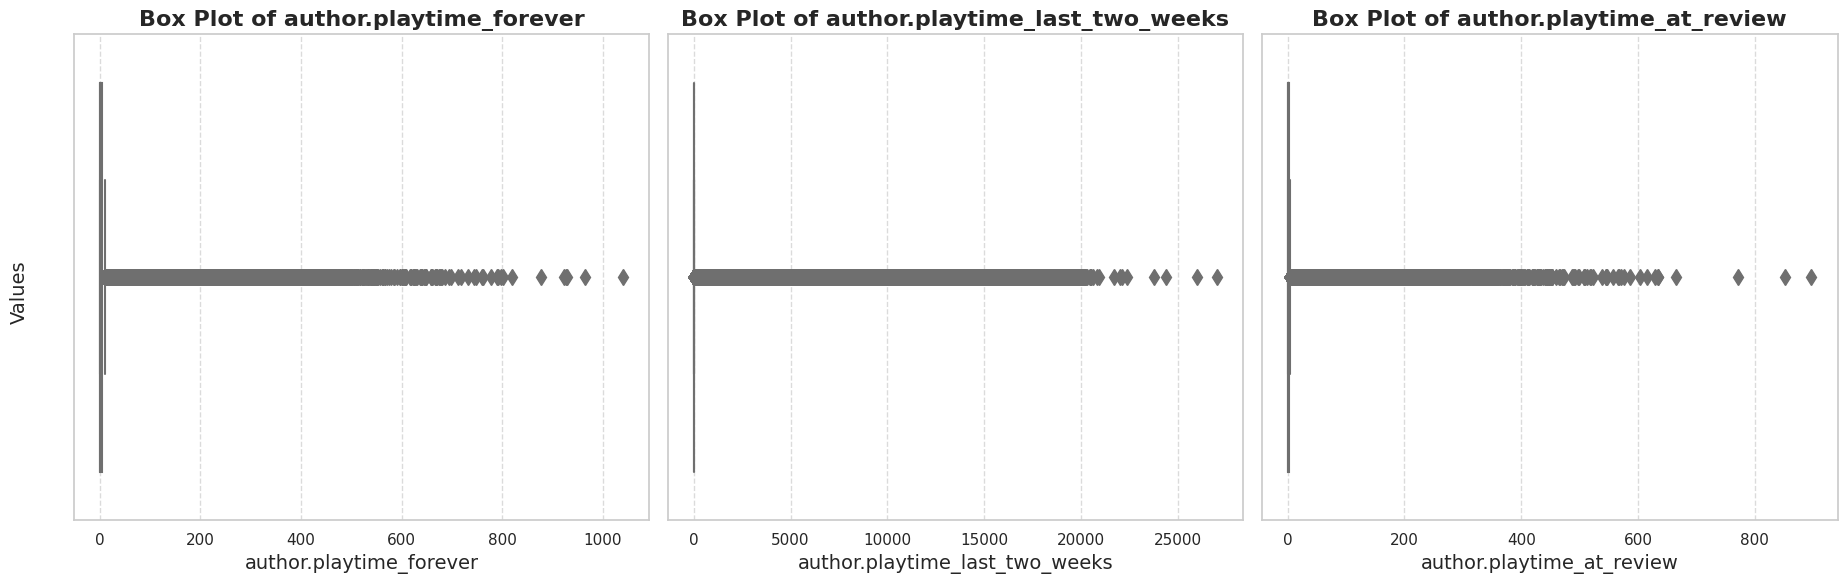

In [46]:
numerical_vars = ['author.playtime_forever', 'author.playtime_last_two_weeks', 'author.playtime_at_review']
sns.set(style="whitegrid")

# Set up the figure and the subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Loop through the numerical variables and axes to plot each box plot in its subplot
for i, var in enumerate(numerical_vars):
    sns.boxplot(x=df[var], ax=axes[i], color='skyblue', fliersize=8, linewidth=1.5)
    axes[i].set_title(f'Box Plot of {var}', fontsize=16, weight='bold')
    axes[i].set_xlabel(var, fontsize=14)
    axes[i].grid(axis='x', linestyle='--', alpha=0.7)
fig.text(-0.02, 0.5, 'Values', va='center', ha='center', fontsize=14, rotation='vertical')

plt.tight_layout()
plt.show()


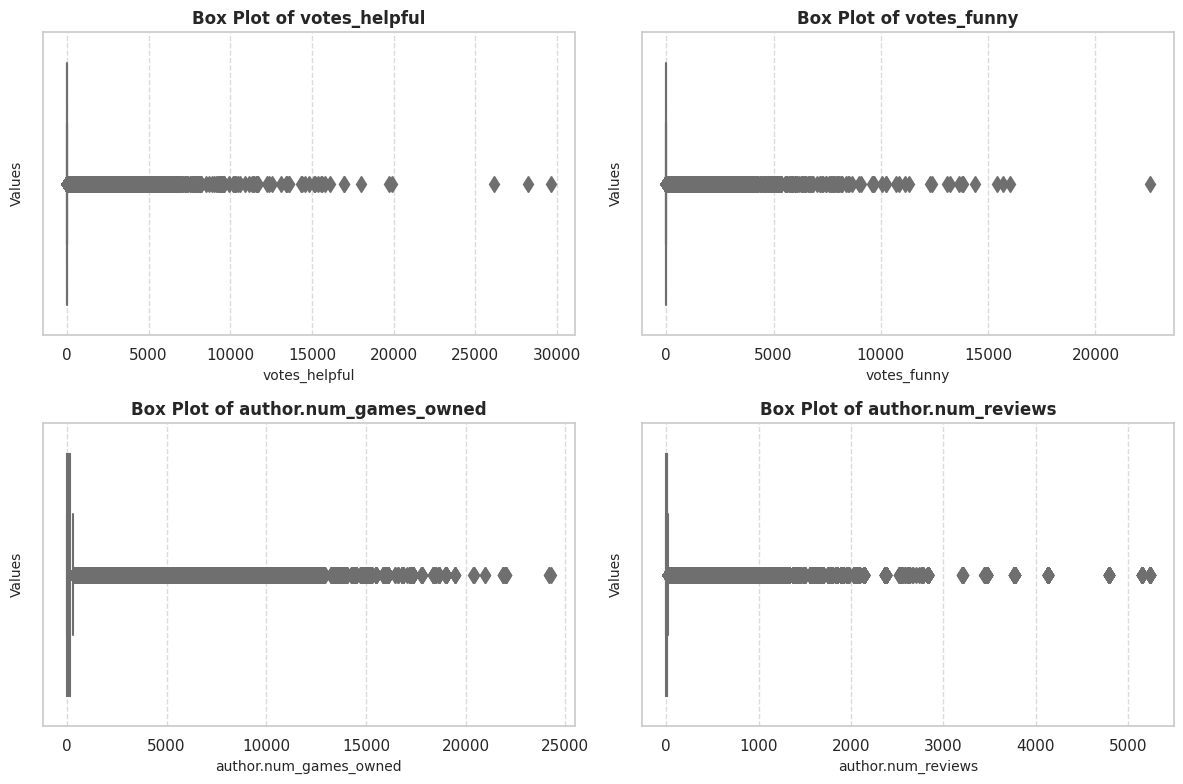

In [37]:
numerical_vars = ['votes_helpful', 'votes_funny', 'author.num_games_owned', 'author.num_reviews']
sns.set(style="whitegrid")

# Set up the 2x2 figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Loop through each variable and subplot to to plot each box plot
for i, var in enumerate(numerical_vars):
    sns.boxplot(x=df[var], ax=axes[i], color='skyblue', fliersize=8, linewidth=1.5)
    
    # Set the title and labels for each subplot
    axes[i].set_title(f'Box Plot of {var}', fontsize=12, weight='bold')
    axes[i].set_xlabel(var, fontsize=10)
    axes[i].set_ylabel('Values', fontsize=10)
    axes[i].grid(axis='x', linestyle='--', alpha=0.7)
    
plt.tight_layout()
plt.show()

From the box plots above, we can see that all numeric variables now have reasonable values. While there are still outliers, they fall within a closer range, thanks to the pre processing phase.

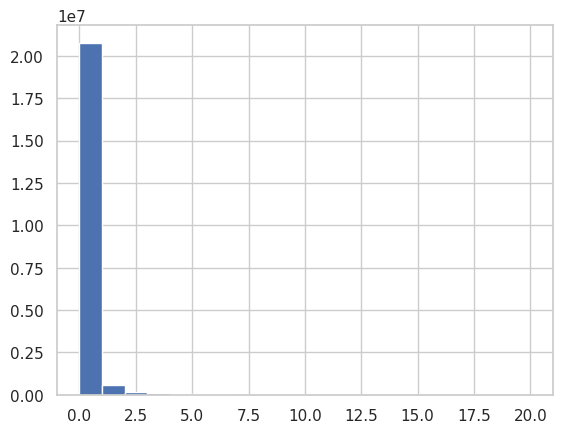

In [38]:
plt.hist(df['comment_count'], range = [0, 20], bins = 20);

As we can see from this plot above most of the reviews have zero comments, we just have a little proportion with more than one. 

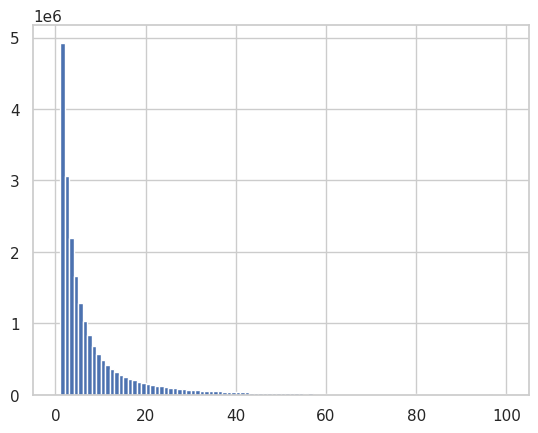

In [39]:
plt.hist(df['author.num_reviews'], range = [0, 100], bins = 100);

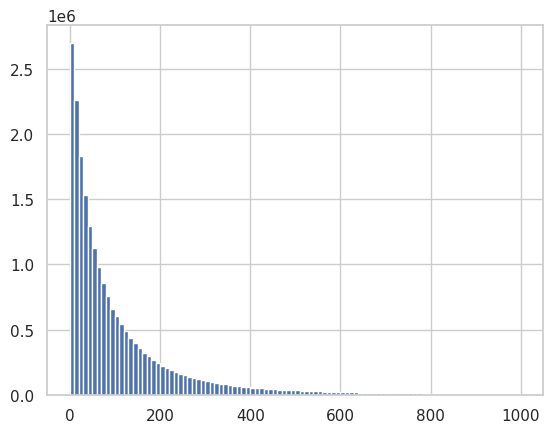

In [40]:
plt.hist(df['author.num_games_owned'], range = [0, 1000], bins = 100);

In graphs derived from social networks, a power law distribution can be observed, and this is what we find here for many of the variables - a small number of reviews and authors are vastly more popular than the other ones.

Let's analyze the correlation between the (numeric) variable to look at some pattern in data.
When two variables are correlated they tend to move together, basically when have a change in one then we have a change also in the other.

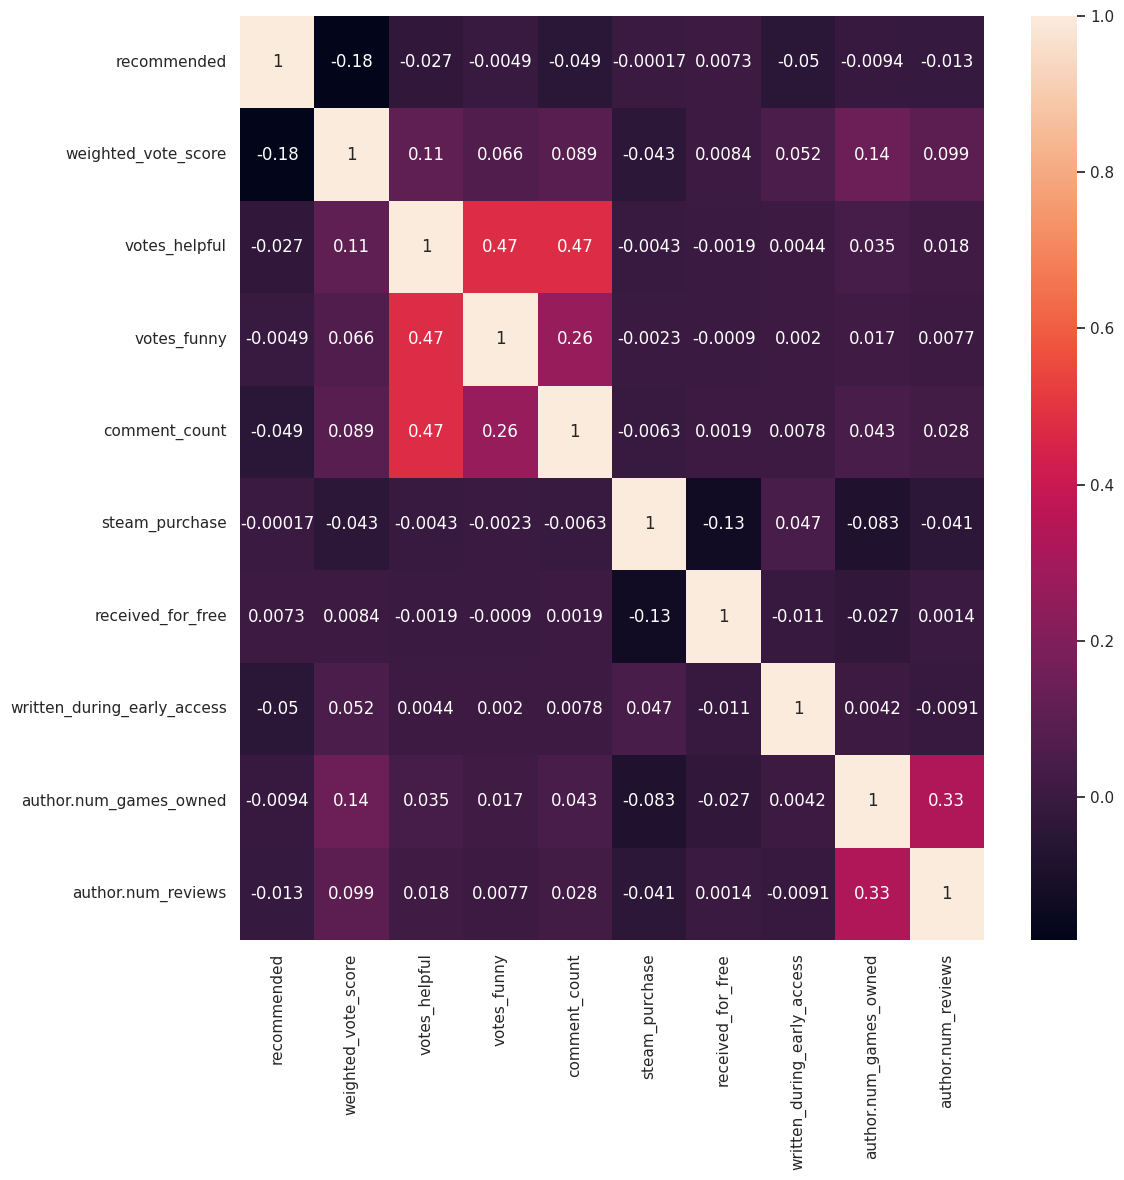

In [41]:
fig = plt.figure(figsize=(12,12))
columns_to_keep = ['recommended', 'weighted_vote_score', 'votes_helpful', 'votes_funny', 'comment_count', 'steam_purchase', 'received_for_free', 'written_during_early_access', 'author.num_games_owned',
                   'author.num_reviews']
mat_corr = df[columns_to_keep].corr()
sns.heatmap(mat_corr, annot= True)
plt.show()

For example, we can examine the correlation between *votes_funny* and *votes_helpful*, which suggests that users often find funny comments to be helpful as well, and vice versa.

Additionally, it's interesting to note that if a review is marked as helpful, users are more likely to comment on it. This correlation can be explained by the fact that the comments are likely expressions of appreciation for such a thorough review. We can observe a similar behavior when a review is considered funny, though with less intensity. In this case, for example, the comments may be humorous.

In conclusion, we observe a positive correlation between the number of games owned by an author and the number of reviews they write. Naturally, owning more games tends to result in writing more reviews.

# [RQ2]
*Let's explore the dataset by analyzing the distribution of reviews across different applications.*

- Identify which applications have the highest and lowest number of reviews.
- Plot the number of reviews for each application in descending order. What insights can you draw from the plot?
- For the top 5 applications by number of reviews, how many reviews came from users who purchased the application versus those who received it for free?
- Provide a percentage breakdown and highlight any similarities.
- Which applications have the most and the least user recommendations?
- Summarize your findings.
- Is there a correlation between the number of recommendations and the applications' review scores? Use a statistical test to confirm the significance of the relationship.

We can see the top-N and bottom-N games by review count like shown below for top 3 and bottom 3. By default, if we print the time series by itself, it will show the top 5 and bottom 5.

In [42]:
reviews_by_app = df['app_name'].value_counts()

In [43]:
print(reviews_by_app[:3])

app_name
PLAYERUNKNOWN'S BATTLEGROUNDS     1644254
Grand Theft Auto V                1019116
Tom Clancy's Rainbow Six Siege     841918
Name: count, dtype: int64


In [44]:
print(reviews_by_app[-3:])

app_name
Shadow Complex Remastered    700
DRAGON QUEST HEROES™ II      600
Neon Hardcorps               200
Name: count, dtype: int64


In [64]:
# Group by app_name and count the reviews each app received, then sort in descending order
app_review_sorted = df['app_name'].value_counts().sort_values(ascending=False)

num_bars = len(app_review_sorted)
mako_colors = sns.color_palette("crest", num_bars).as_hex()

# Bar chart with gradient color mapping
fig = go.Figure(data=[go.Bar(
    x=app_review_sorted.index,
    y=app_review_sorted.values,
    marker_color=mako_colors,
    text=app_review_sorted.values,
    textposition='auto'
)])
fig.update_layout(
    title="Number of Reviews per Application",
    xaxis_title="Application Name",
    yaxis_title="Number of Reviews",
    template="plotly_white",
    title_font=dict(size=24, color='black', family='Arial'),
    yaxis_title_font=dict(size=16, color='black'),
    xaxis=dict(showticklabels=False)  # This line removes the x-axis tick labels
)
fig.show()

By plotting the number of reviews for each app, we can see that the distribution mostly follows a power law distribution, with a few games being orders of magnitude more popular than the vast majority of games. Something that can be noticed is that a lot of the top games by review count are games where multiplayer gameplay is a large focus, indicating that people might have a preference for playing games together as opposed to on their own, and many are also games that came out many years ago (such as Grand Theft Auto V, Terraria, Garry's Mod, as seen in the list below), and have had more time to accumulate reviews.

In [46]:
top_5_apps = reviews_by_app.index[:5]
top_5_apps

Index(['PLAYERUNKNOWN'S BATTLEGROUNDS', 'Grand Theft Auto V',
       'Tom Clancy's Rainbow Six Siege', 'Terraria', 'Garry's Mod'],
      dtype='object', name='app_name')

In [47]:
df_top_5 = df[df['app_name'].isin(top_5_apps)]
df_top_5.head()

,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,...,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
907627,4000,Garry's Mod,85009532,english,"great game, just dont leave then game for like...",2021-01-20 02:39:41,2021-01-20 02:39:41,True,0,0,...,True,False,False,76561199079384007,11,3,6632.0,240.0,6618.0,2021-01-20 02:54:59
907628,4000,Garry's Mod,85009402,english,NaN,2021-01-20 02:35:45,2021-01-20 02:35:45,True,0,0,...,True,False,False,76561199008804411,18,16,3142.0,26.0,3115.0,2021-01-20 03:02:09
907629,4000,Garry's Mod,85009374,english,sssss,2021-01-20 02:35:03,2021-01-20 02:35:03,True,0,0,...,True,False,False,76561199038959941,5,2,9518.0,15.0,9518.0,2021-01-20 02:34:41
907630,4000,Garry's Mod,85009235,russian,FepFep,2021-01-20 02:31:07,2021-01-20 02:31:07,False,0,0,...,True,False,False,76561198170950578,45,2,152235.0,1480.0,152235.0,2021-01-20 00:25:30
907631,4000,Garry's Mod,85009000,english,I have over 600 mods.,2021-01-20 02:23:37,2021-01-20 02:23:37,True,0,0,...,True,False,False,76561198107085835,327,37,60448.0,36.0,60448.0,2021-01-16 00:50:51


In [48]:
s = df_top_5['app_name'].value_counts()
s

app_name
PLAYERUNKNOWN'S BATTLEGROUNDS     1644254
Grand Theft Auto V                1019116
Tom Clancy's Rainbow Six Siege     841918
Terraria                           672815
Garry's Mod                        655524
Name: count, dtype: int64

In [49]:
temp = pd.DataFrame(df_top_5.groupby(['app_name'])['steam_purchase'].sum())
temp['received_for_free'] = df_top_5.groupby(['app_name'])['received_for_free'].sum()
with_total_count = pd.merge(temp, s, left_index = True, right_index = True)
with_total_count['% bought on Steam'] = with_total_count['steam_purchase']  / with_total_count['count'] * 100
with_total_count['% received for free'] = with_total_count['received_for_free']  / with_total_count['count'] * 100
with_total_count.sort_values(by = ['count'], ascending = False)

,steam_purchase,received_for_free,count,% bought on Steam,% received for free
app_name,,,,,
PLAYERUNKNOWN'S BATTLEGROUNDS,1372721,61443,1644254,83.485946,3.736831
Grand Theft Auto V,905288,38624,1019116,88.830712,3.789951
Tom Clancy's Rainbow Six Siege,702505,36300,841918,83.441024,4.311584
Terraria,527762,20154,672815,78.440879,2.995474
Garry's Mod,551250,24765,655524,84.093031,3.777894


In terms of the counts of reviews coming from Steam purchases, and the counts of reviews where the game was received for free, it's interesting that summing these two does not add up to the total number of reviews per game - it's lower, because a game can also be reviewed if it was neither purchased on Steam nor received for free on Steam, for example, if the purchase of the Steam key was made elsewhere, or the reviewer had access to the game through family sharing, etc. This is why the percentages don't add up to 100%. However, we can see overall that a big majority of reviews are coming from purchases on Steam.

In [50]:
recommended = df[df['recommended'] == True]
rec_by_app = recommended['app_name'].value_counts()
print(rec_by_app)

app_name
PLAYERUNKNOWN'S BATTLEGROUNDS     886416
Grand Theft Auto V                831311
Tom Clancy's Rainbow Six Siege    742397
Terraria                          658741
Garry's Mod                       632558
                                   ...  
Out of the Park Baseball 19          594
Shadow Complex Remastered            587
Identity                             439
DRAGON QUEST HEROES™ II              423
Neon Hardcorps                        89
Name: count, Length: 315, dtype: int64


In [51]:
print(rec_by_app[:3])

app_name
PLAYERUNKNOWN'S BATTLEGROUNDS     886416
Grand Theft Auto V                831311
Tom Clancy's Rainbow Six Siege    742397
Name: count, dtype: int64


In [52]:
print(rec_by_app[-3:])

app_name
Identity                   439
DRAGON QUEST HEROES™ II    423
Neon Hardcorps              89
Name: count, dtype: int64


 The top 5 apps by user recommendations are the same ones that are the top 5 by number of reviews in general, and in the same order, as well. In general, we can guess at a strong correlation between the number of reviews and the number of recommendations based on these findings.

In [53]:
stats.pearsonr(reviews_by_app, rec_by_app)

PearsonRResult(statistic=0.9720315067954295, pvalue=5.294037568139408e-199)

It's not entirely clear what 'review scores' means, because there isn't a column for each review in the dataset where the games are being scored. However, if we're testing for correlation between the number of reviews by app, and the number of recommendations by app, we can see that there's a very strong positive linear correlation according to the Pearson test, meaning that the likelihood of a game being recommended roughly stays the same relative to the number of reviews it gets. We could have also used a non-linear test such as Spearman's rank correlation coefficient, but with such a high linear correlation, it's not mandatory.

If we build our own column that takes the number of recommendations per app, divided by the number of reviews for that app, we'd essentially be comparing the column of recommendations to itself but 'scaled', so we would still expect a big linear correlation.

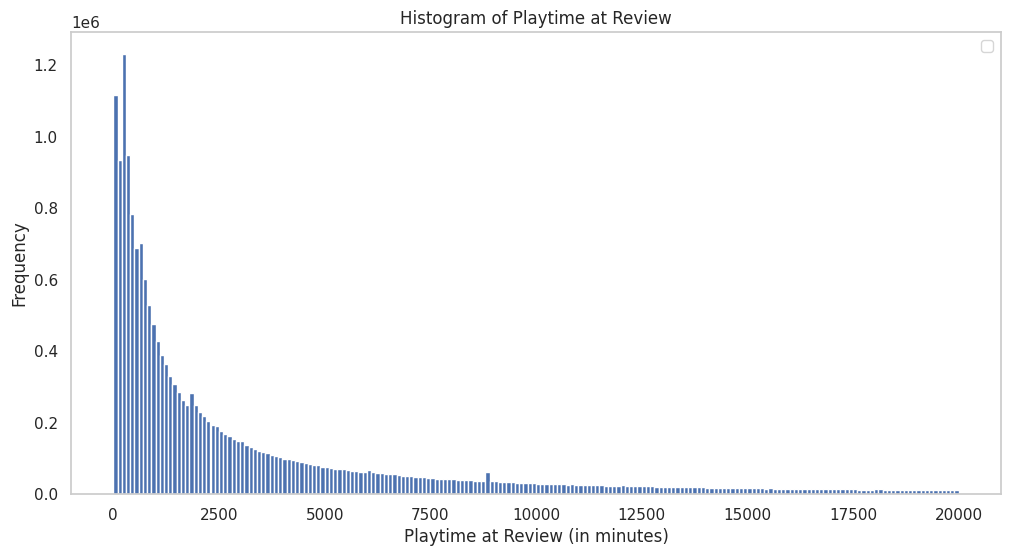

In [67]:
plt.figure(figsize=(12, 6))
plt.hist(df['author.playtime_at_review'], range = [0, 20000], bins = 200);
plt.title('Histogram of Playtime at Review')
plt.xlabel('Playtime at Review (in minutes)')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

# [RQ3]
*Understanding when users are most active in submitting reviews can help identify peak engagement periods.*

- Plot the number of reviews submitted each month and describe any trends.
- Identify any seasonal patterns or trends in review activity. Explain any seasonal impact you notice.
- Determine if certain times of the year have higher engagement rates. Describe noticeable peaks in user activity.
- What is the most common time of day users write reviews? For example, users might typically write reviews at 17:44. Explain how this time distribution could influence your analysis.
- Create a function that accepts a list of time intervals and plots the number of reviews for each interval.
- Use the function to plot the number of reviews for the following time intervals:

In [68]:
# Use 'period' for a new column called month
df['month']= df['timestamp_created'].dt.to_period('M')

In [69]:
# Group by timestamp and the new column month and use count to figure out how many review per month
df['month'] = df['timestamp_created'].dt.month

# Let's groupd by 'month_only' and count the occurences
review_month_only = df.groupby('month').size()

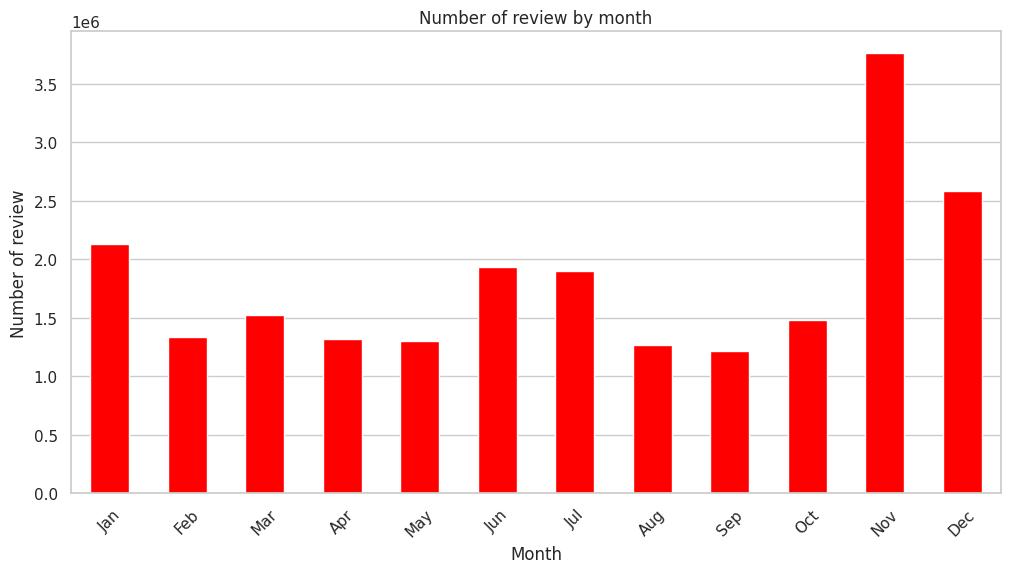

In [70]:
# Bar plot of number of review per month
review_month_only.plot(kind='bar', figsize=(12, 6), color='red');
plt.title('Number of review by month')
plt.xlabel('Month')
plt.ylabel('Number of review')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation = 45)
plt.grid(axis = 'x')
plt.show()

In this graph, we can observe that certain months have higer review activity, suggesting that people review game more during certain timms of the year. In particular, in June, July, November, December and January users write more reviews. This pattern likely reflects holiday periods, as summer holidays and Christmas holidays, those are the periods when people, kids in particular, generally have more free time. Another seasonal factor could be the typical release dates for major games, usually timed around summer, September or October. This means that, after some time playing the new games, they are more likely to write a review. In fact, November is the month with the most reviews.

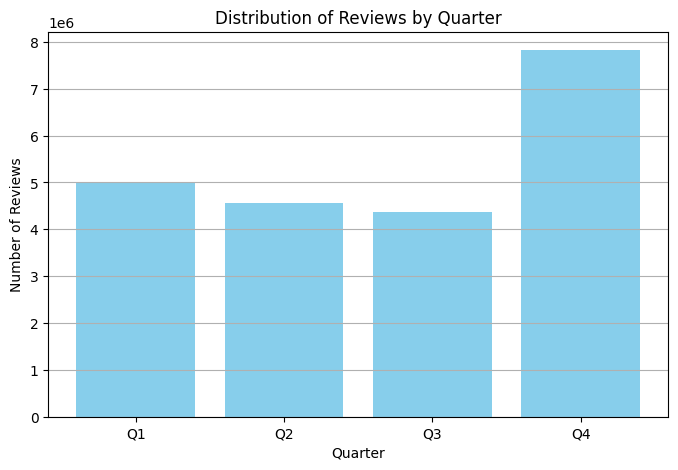

In [91]:
# Map each month to its corresponding quarter
df['quarter'] = df['month'].apply(lambda x: 'Q1' if x in [1, 2, 3] else
                                              'Q2' if x in [4, 5, 6] else
                                              'Q3' if x in [7, 8, 9] else 'Q4')

# Count the occurrences in each quarter
quarter_counts = df['quarter'].value_counts().sort_index()

# Barplot
plt.figure(figsize=(8, 5))
plt.bar(quarter_counts.index, quarter_counts.values, color='skyblue')
plt.title('Distribution of Reviews by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Number of Reviews')
plt.grid(axis = 'y')
plt.show()

This graph represent the distribution of reviews across the four quarters of the year and each one aggregates the number of reviews received in the three months of the period. This graph indicates that Q4 is the quarter with the most reviews while the others have similar number of reviews.
However, grouping by quarters could be misleading and important information may be lost. In fact, analyzing it we may think that every month in Q4 has an high number of reviews but in reality November has many more reviews than December and particularly October. The same applies to January, June and July - these are some of the months with most reviews but it wouldn't be enough to look at the quarterly distribution to observe that.

In [48]:
# Create a new column called 2weeks using the isocalendar function
df['2weeks'] = (df['timestamp_created'].dt.isocalendar().week // 2)

In [49]:
# Group the data for every two weeks of the year and sum all the playtimes in those weeks
playtime_2weeks = df.groupby('2weeks')['author.playtime_last_two_weeks'].sum()

In [50]:
# Plotly Connected Scatter Plot
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=playtime_2weeks.index,
    y=playtime_2weeks.values,
    mode='lines+markers',
    marker=dict(color='blue', size=8),
    line=dict(color='blue'),
    hovertemplate='Period: %{x}<br>Game Time: %{y}<extra></extra>'  # Custom hover template
))
fig.update_layout(
    title='Game time every two weeks',
    xaxis_title='Period (every two weeks)',
    yaxis_title='Game Time (seconds)',
    template='plotly_white',
    width=1000,  # Width of the figure(pixels)
    height=600   # Height of the figure(pixels)
)

# Adding grid
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.show()

This graph represent user engagement based on the hours played every two weaks measured using the 'author.playtime_last_two_weeks' feature. The data reveals some peaks in user activity: there is an important peak the first few weeks of the year and also the last few weeks with the highest level of hours played in November. Between these two peaks, playtime remains low and stable except for one time of the year that coincides with summer holiday, which is when children have more free time.

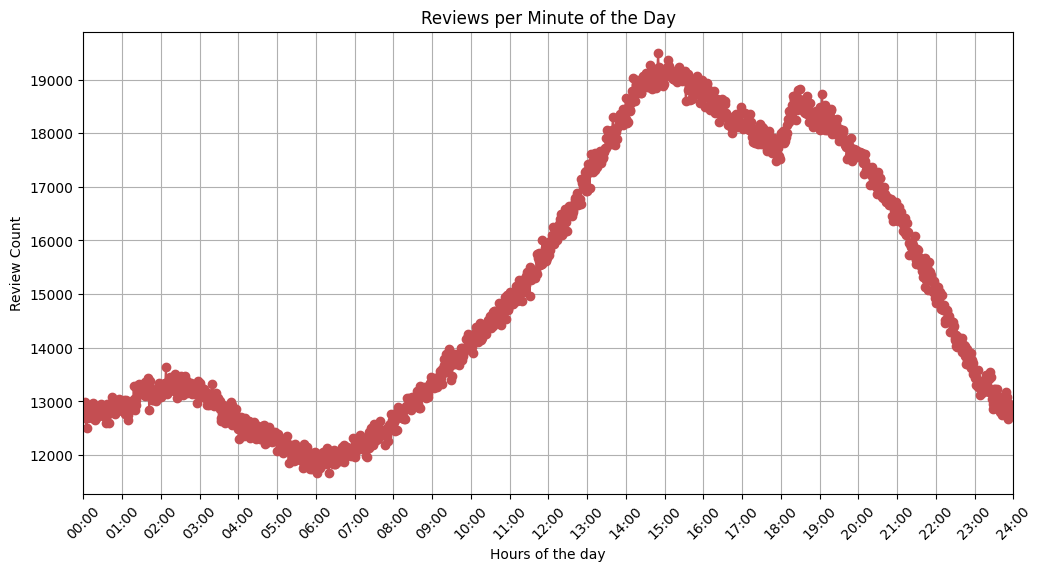

In [88]:
plt.style.use('default')
# Create a new column called 'every_minute' that calculates the minute of the day for each review
df['every_minute'] = df['timestamp_created'].dt.hour * 60 + df['timestamp_created'].dt.minute

# Group the reviews by the column 'every_minute' and count how many reviews were written at each minute of the day
review_per_minutes = df.groupby('every_minute')['review_id'].count()

plt.figure(figsize=(12, 6))
plt.plot(review_per_minutes.index, review_per_minutes.values, marker='o', linestyle='-', color='r')
plt.grid()

# Set label of x-axis to represent every hour and minute of the day
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(60)) 
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'{int(x // 60):02d}:{int(x % 60):02d}'))

plt.xlabel('Hours of the day')
plt.ylabel('Review Count')
plt.title('Reviews per Minute of the Day')
plt.xticks(rotation=45)
plt.xlim(0, 1440)
plt.show()

This plot represents the distribution of reviews over the course of the day and each data point indicates the number of reviews written at a particular minute. As we can see, the number of reviews starts to increase in the early morning and than reaches a peak around early afternoon staying more or less at the same level until 7pm. This pattern suggests that most users are likely to write a review after school or work hours, when people have more free time. After 7pm the number of reviews starts decreasing and there are fewer reviews after midnight until the early hours of the morning, which is when people are likely sleeping.

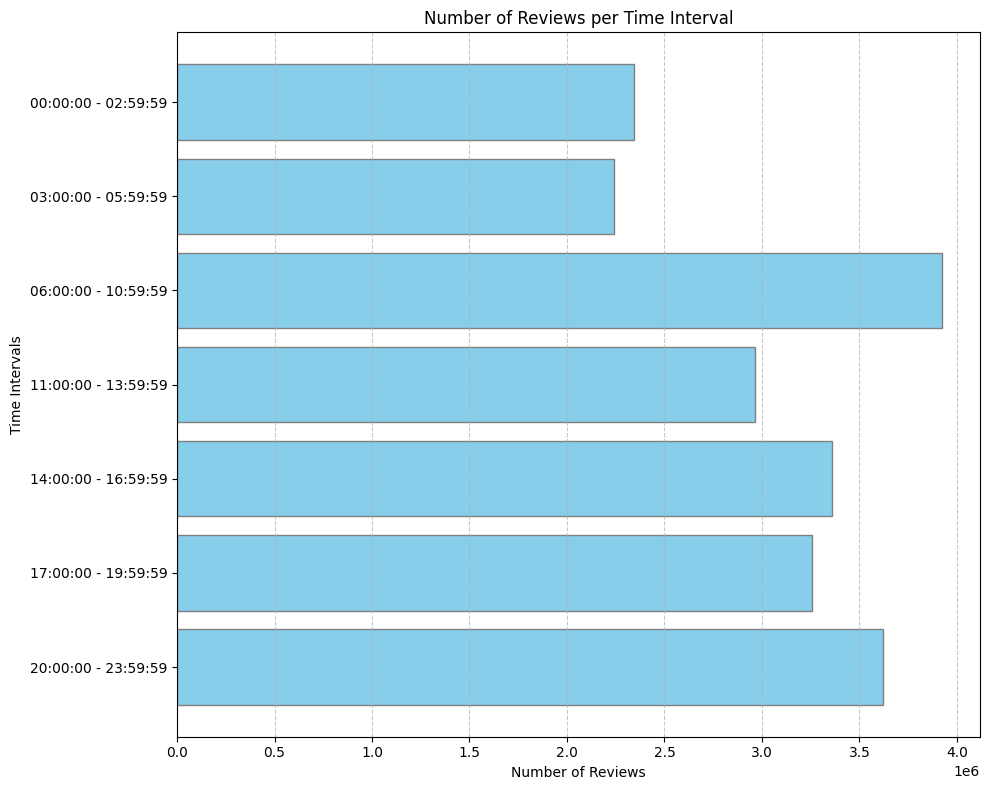

In [89]:
# Define time intervals
time_intervals = [
    ("00:00:00", "02:59:59"),
    ("03:00:00", "05:59:59"),
    ("06:00:00", "10:59:59"),
    ("11:00:00", "13:59:59"),
    ("14:00:00", "16:59:59"),
    ("17:00:00", "19:59:59"),
    ("20:00:00", "23:59:59")
]

# This function takes in input 'time' that represents a list in which every element is a time interval and a DataFrame.
def reviw_per_interval(time, dataset):
    number_of_review = []
    # Just take the time, exclude the date
    dataset['times'] = dataset['timestamp_updated'].dt.time

    # This for loop iterates over each interval in the list time: the start and end times
    for i, j in time:
        start = datetime.strptime(i, "%H:%M:%S").time()
        end = datetime.strptime(j, "%H:%M:%S").time()
        # For every iteration it checks if the review time is >= to the start and <= to the end of the interval and counts the reviews for that interval
        date_time = dataset[(dataset['times'] >= start) & (dataset['times'] <= end)]['review'].count()
        number_of_review.append(date_time)
        
    time_labels = [f"{i} - {j}" for i, j in time]

    # Reverse the counts and labels to match the original order
    number_of_review.reverse()
    time_labels.reverse()

    # Horizontal bar chart
    plt.figure(figsize=(10, 8))
    plt.barh(time_labels, number_of_review, color='skyblue', edgecolor='gray')  # Horizontal bar, custom color, and edge color
    plt.xlabel("Number of Reviews")
    plt.ylabel("Time Intervals")
    plt.title("Number of Reviews per Time Interval")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

reviw_per_interval(time_intervals, df)

This graph represents how many reviews were written during some part of the day. Notably, there are two peaks during the intervals 6:00-10:59 and 20:00-23:59, but this is because these intervals include more hours than the others. Finally, it's important to underline that the two intervals 14:00-16:59 and 17:00-19:59 which include only 3 hours, instead of 4, still show significant review activity. In fact, as seen in the previous analyses, the 14:00-20:00 interval is when the highest number of reviews are written. So, this graph confirms the pattern where users are highly active in the afternoon compared to the other parts of the day.

# [RQ4]
*Investigating whether users who spend more time using an application give higher or lower ratings.*

- Analyze the relationship between the amount of time a user has spent on an application and their review score.
- Do more experienced users (who have used the application longer) tend to give higher or lower ratings? Comment on any trends you observe.
- Plot the distribution of review scores based on different user experience levels (e.g., new users vs. veteran users). Is there a statistical difference in the score distributions? Use an appropriate statistical test to validate your hypothesis.
- Ask an LLM tool (ChatGPT, Claude AI, etc.) to interpret the statistical results of the analysis and provide potential explanations for the trends. Does the LLM suggest additional factors that could explain why users who spend more time on the app give higher or lower ratings? How can you validate the interpretations provided by the LLM?

Firstly we tried to build our own *review_score* variable, calculated as the number of recommendation over the total number of review for each game.
But the use of it, obviously, does not give to each review a specific score, instead it consider for every review of a specific game the same value.
This is going to introduce bias in the analysis because instead of considering a numerical variable from the point of view of the reviewer we are considering a categorical variable where each category is represented as a the number of recommendation for each game.
We will plot the distribution considering this variable right below.

To have a value that is representative of each reviewer we considered the *weighted_vote_score* column that represents a score for each review weighting the helpful and funny votes for that review, among other factors. This column basically represents the opinion and the interaction of the community with respect to that specific review, so it fits well to our purpose.

In [22]:
# Convert the values in percentage
df['weighted_vote_score'] = df['weighted_vote_score'] * 100

Convert both *author.playtime_at_review* and *author.playtime_forever* from seconds to hours, for a better usage in analysis and visualization.

In [23]:
df['author.playtime_at_review'] = df['author.playtime_at_review'] / 3600

In [24]:
df['author.playtime_forever'] = df['author.playtime_forever'] / 3600

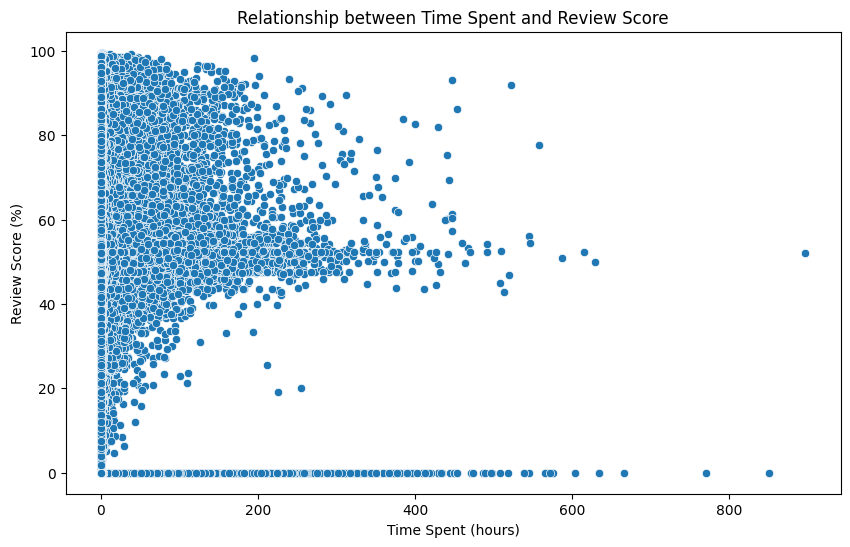

In [99]:
# Scatter plot of authore.playtime_at_review vs weighted_vote_score
plt.figure(figsize=(10, 6))
sns.scatterplot(x='author.playtime_at_review', y='weighted_vote_score', data=df)
plt.title('Relationship between Time Spent and Review Score')
plt.xlabel('Time Spent (hours)')
plt.ylabel('Review Score (%)')
plt.show()

In [101]:
# Number of users with weighted_vote_score equal to 0 
print(len(df[df['weighted_vote_score'] == 0]))

14771012


In [104]:
# Number of users with play_time_at_review lower than 1 
print(len(df[df['author.playtime_at_review'] < 1]))

13791451


There isn't a clear correlation between the author's playtime and the review score, because the score is measuring the engagement of the other users with the review, as opposed to the 'quality' of the review itself. So, a small number of reviews are going viral and receiving a lot of helpful and funny votes, whereas many genuinely useful reviews may be buried, and if they get no helpful or funny votes, their review score is 0, even if the author played the game for a long time.

In [105]:
# Number of users with weighted_vote_score equal to 0 and play_time_at_review lower than 1
print(len(df[(df['author.playtime_at_review'] < 1) & (df['weighted_vote_score'] == 0)]))

9381108


It is important to note, however, that most players are concentrated in the points where they have less than one hour of playtime and a review score of 0.

In [25]:
# Count the number of rows where 'author.playtime_at_review' < 1 and 'recommended' == False
count = df[(df['author.playtime_at_review'] < 1) & (df['recommended'] == False)].shape[0]
print(f"Number of users with less than one hour played and not recommend the game: {count}")

Number of users with less than one hour played and not recommend the game: 1560406


At the same time, we can explain the large portion of users who have played for less than an hour and still review the game. This group of users likely consists of those who attempt to play a game but encounter continuous crashes, frame drops, and various issues. They experience a negative experience with the game, which leads to a poor review. However, if the rest of the community shares the same experience, it tends to positively validate that review.

In [26]:
correlation = df['author.playtime_at_review'].corr(df['weighted_vote_score'])
print(f'Correlation between time spent on an application and review score: {correlation}')

Correlation between time spent on an application and review score: 0.009922392013144434


The correlation coefficient is low, as expected from the nature of the variables.

To analyze the distribution of review scores based on different user experience levels, first of all we need to create our variable *user_experience* considering groups based on the time spent playing the reviewed game.

In [28]:
# Define thresholds
low_threshold = 10
high_threshold = 200

# Get the categorical variable 'user_experience' basing on the user's playtime
df['user_experience'] = df['author.playtime_forever'].apply(
    lambda x: 'New player' if 0 < x < low_threshold
    else 'Casual player' if low_threshold <= x < high_threshold
    else 'Veteran'
)
# Check the user_experience distribution
df['user_experience'].value_counts()

user_experience
New player       19196177
Casual player     2546532
Veteran              4656
Name: count, dtype: int64

The largest group is, expectedly, the users that have played the game for a very short time. 

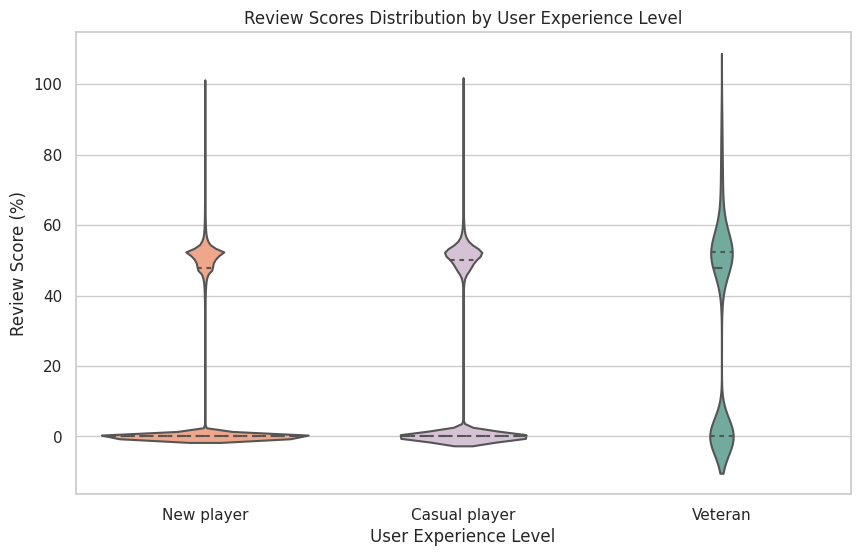

In [69]:
# Violin Plot
plt.figure(figsize=(10, 6))
colors = ['#FFA07A', '#D8BFD8', '#69b3a2']
sns.violinplot(x='user_experience', y='weighted_vote_score', data=df, inner="quartile", palette=colors)
plt.title('Review Scores Distribution by User Experience Level')
plt.xlabel('User Experience Level')
plt.ylabel('Review Score (%)')
plt.show()

During our analysis of the relationship between playtime and review scores, we observed a notable trend: players with a significant amount of playtime tend to receive higher review scores. This trend is clearly illustrated in the plot above, which shows that players with more than 200 hours logged generally receives higher scores compared to those with fewer hours.

This finding is not unexpected; typically, players who enjoy a game tend to invest more time in it, leading them to develop a more nuanced understanding and appreciation of its features. Consequently, their feedback is often deemed more valuable by the community.

The violin plot further highlights this trend. We see that many new players have a review score of 0, likely due to their limited experience and familiarity with game mechanics, so the usually cant give a deeper opinion about that game, as a consequence less people appreciate their reviews. In contrast, among casual players, the number of players with a score of 0 decreases, while we also observe a rise in the number of players receiving higher scores. Finally, veteran players exhibit the lowest proportion of 0 review scores and the highest representation of players receiving elevated review scores.

This analysis suggests that as players invest more time in games, their ratings become more positive, reflecting their deeper engagement and understanding of the gaming experience, and the greater appreciation from the community of their reviews.

To validate the hypothesis that players with more hours played tend to receive a higher review score, we use a statistical test to determine if the differences between the groups are statistically significant. In particular, we will employ the ANOVA test, which compares the means of more than two groups (in our case, three groups). To conduct this analysis, as with all statistical tests, we will calculate our test statistic, which is explained in the subsequent code cells, and we will check the p-value. To establish statistical significance, we require a p-value below our significance level (0.05). Therefore, if the p-value is less than 0.05, we can conclude that the means between the groups are statistically different.

In [29]:
# Define the mean of the groups
group_new = df[df['user_experience'] == 'New player']['weighted_vote_score']
group_mean_exp = df[df['user_experience'] == 'Casual player']['weighted_vote_score']
group_veteran = df[df['user_experience'] == 'Veteran']['weighted_vote_score']

# Perform One-Way ANOVA, directly with python package 'stat'
stat, p_value = f_oneway(group_new, group_mean_exp, group_veteran)
print(f"One-Way ANOVA Test statistic: {stat}, p-value: {p_value}")

One-Way ANOVA Test statistic: 16672.41687981119, p-value: 0.0


We can also perform the ANOVA test independently by calculating the between-group variance (i.e., the variance among the groups) and the within-group variance (i.e., the variance within the groups). Next, we obtain the between-group sum of squares and the within-group sum of squares by dividing by the degrees of freedom for the groups in the first case and by the degrees of freedom for the model in the second. This allows us to compute our F-test statistic, which is calculated as the ratio of the between-group sum of squares to the within-group sum of squares.

Subsequently, we calculate the critical value of the F statistic (also known as the F value) concerning our significance level (alpha = 0.05) and our degrees of freedom for the groups and the model. Finally, to determine if there is a statistically significant difference between the means of the groups, we check if our F statistic is greater than the critical value. If it is, then a statistically significant difference exists.

In [31]:
mean_total = df['weighted_vote_score'].mean()

# Compute the means for each group
group_means = df.groupby('user_experience')['weighted_vote_score'].mean()

# Compute SS_between (sum of the squared differences between the group means and the overall mean)
group_sizes = df['user_experience'].value_counts()
SS_between = sum(group_sizes[group] * (group_mean - mean_total) ** 2
                 for group, group_mean in group_means.items())

# Compute SS_within (sum of the squared differences within each group relative to its own mean)
SS_within = sum(((df[df['user_experience'] == group]['weighted_vote_score'] - group_mean) ** 2).sum()
                for group, group_mean in group_means.items())

# Degrees of freedom
k = len(group_means)  # Number of groups
N = len(df)  # Number of total observations
df_between = k - 1  # Between's degree of freedom
df_within = N - k  # Within's degrees of freedom

# Compute MS_between e MS_within
MS_between = SS_between / df_between
MS_within = SS_within / df_within

print(f'SS_between: {SS_between}, SS_within: {SS_within}, MS_between: {MS_between}, MS_within: {MS_within}, df_between: {df_between}, df_within: {df_within}')

SS_between: 19724519.97968551, SS_within: 12864249957.481693, MS_between: 9862259.989842756, MS_within: 591.5315134535257, df_between: 2, df_within: 21747362


In [35]:
from scipy.stats import f
F_computed = MS_between / MS_within

# Significance level (alpha = 0.05) and computation of the critical value of F
alpha = 0.05
F_critic = f.ppf(1 - alpha, df_between, df_within)

print(f'F_computed: {F_computed}, F_critic: {F_critic}')

F_computed: 16672.416879811077, F_critic: 2.9957326864870133


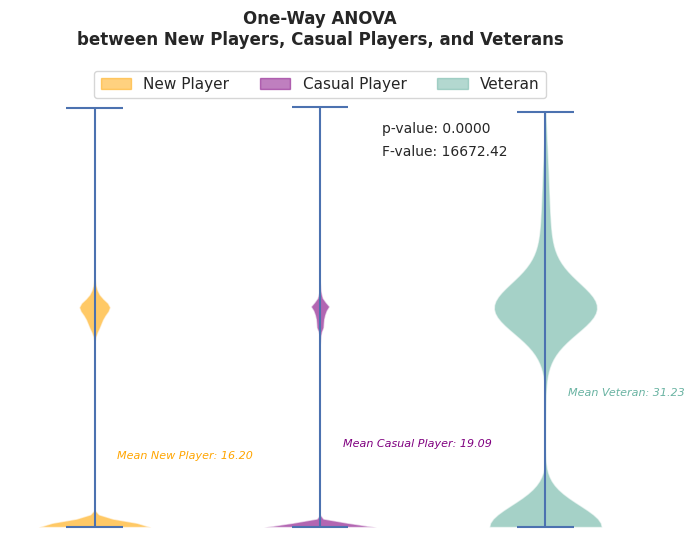

In [71]:
# Perform One-Way ANOVA
from scipy.stats import f_oneway
F_statistic, p_value = f_oneway(group_new, group_mean_exp, group_veteran)

# Calculate mean values for each group
mean_group_new = group_new.mean()
mean_group_mean_exp = group_mean_exp.mean()
mean_group_veteran = group_veteran.mean()

grouped = df.groupby('user_experience')['weighted_vote_score']
fig, ax = plt.subplots(figsize=(8, 6))

# Violin Plot
violins = ax.violinplot([group.values for name, group in grouped], showmeans=False)
colors = ['orange', 'purple', '#69b3a2']

# Apply colors to each violin body
for violin, color in zip(violins['bodies'], colors):
    violin.set_facecolor(color)
    violin.set_alpha(0.6)

# Display ANOVA p-value and F-value
p_value_text = f'p-value: {p_value:.4f}'
ax.text(0.6, 0.9, p_value_text, transform=ax.transAxes, fontsize=10)
F_value_text = f'F-value: {F_statistic:.2f}'
ax.text(0.6, 0.85, F_value_text, transform=ax.transAxes, fontsize=10)

# Display the mean for each group
ax.text(1.1, mean_group_new, f'Mean New Player: {mean_group_new:.2f}', style='italic', fontsize=8, color='orange')
ax.text(2.1, mean_group_mean_exp, f'Mean Casual Player: {mean_group_mean_exp:.2f}', style='italic', fontsize=8, color='purple')
ax.text(3.1, mean_group_veteran, f'Mean Veteran: {mean_group_veteran:.2f}', style='italic', fontsize=8, color='#69b3a2')

ax.set_xticks([])
ax.set_yticks([])
ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax.set_title('One-Way ANOVA\nbetween New Players, Casual Players, and Veterans', weight='bold', pad=30)
legend_labels = ['New Player', 'Casual Player', 'Veteran']
legend_handles = [plt.Rectangle((1,1),0.5,0.5, color=color, alpha=0.5) for color in colors]
ax.legend(legend_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)

plt.show()

From the results of the statistical test, we conclude that the difference between the means of the groups is statistically significant.
Also a so high value of the F-value suggest us that the difference is important, at the same time a p-value = 0.0 suggest us that there is no doubt about the statiscal difference between the mean of the three groups just created.
A veteran player understands the pros and cons of a game better, so when they write a review, they have complete knowledge about it, and the community tends to "value" their review, receiving a great and specific review that explains all the cons and pros of that specific game.

Now because the ANOVA test indicates that there is a statistically significant difference between the average ratings of at least one of the groups (new players, casual players, veterans), we try to use a different statistical test that consider the difference between pairs of groups.
To acheive this goal we are going to use the Wilcoxon test that is a non-parametric statistical test used to compare two related groups.

In [36]:
from scipy.stats import mannwhitneyu

# Wilcoxon rank-sum test between pairs of groups
stat_new_mean, p_value_new_mean = mannwhitneyu(group_new, group_mean_exp, alternative='two-sided')
stat_new_veteran, p_value_new_veteran = mannwhitneyu(group_new, group_veteran, alternative='two-sided')
stat_mean_veteran, p_value_mean_veteran = mannwhitneyu(group_mean_exp, group_veteran, alternative='two-sided')

print(f"Wilcoxon test between 'New player' and 'Casual player': statistic = {stat_new_mean}, p-value = {p_value_new_mean}")
print(f"Wilcoxon test between 'New player' and 'Veteran': statistic = {stat_new_veteran}, p-value = {p_value_new_veteran}")
print(f"Wilcoxon test between 'Casual player' and 'Veteran': statistic = {stat_mean_veteran}, p-value = {p_value_mean_veteran}")

alpha = 0.05  # significance level

if p_value_new_mean < alpha:
    print("There is a statistically significant difference between 'New' and 'Mean Experience' users.")
else:
    print("There is no statistically significant difference between 'New' and 'Mean Experience' users.")

if p_value_new_veteran < alpha:
    print("There is a statistically significant difference between 'New' and 'Veteran' users.")
else:
    print("There is no statistically significant difference between 'New' and 'Veteran' users.")

if p_value_mean_veteran < alpha:
    print("There is a statistically significant difference between 'Mean Experience' and 'Veteran' users.")
else:
    print("There is no statistically significant difference between 'Mean Experience' and 'Veteran' users.")

Wilcoxon test between 'New player' and 'Casual player': statistic = 22959084709841.0, p-value = 0.0
Wilcoxon test between 'New player' and 'Veteran': statistic = 31519268173.5, p-value = 0.0
Wilcoxon test between 'Casual player' and 'Veteran': statistic = 4522199349.5, p-value = 3.492909383324477e-231
There is a statistically significant difference between 'New' and 'Mean Experience' users.
There is a statistically significant difference between 'New' and 'Veteran' users.
There is a statistically significant difference between 'Mean Experience' and 'Veteran' users.


As we can see from the results above, all the groups, also considered separately has stastical difference between them.

### ANOVA test

**Question asked to ChatGPT**: Interpret the statistical results of the analysis and provide potential explanations for the trends 


**Answer**:
- Interpretation of Results
    - p-value:

        The p-value of 0.0 indicates that there is a statistically significant difference between the average ratings of at least one of the groups (new players, casual players, veterans). In the context of hypothesis testing, a p-value lower than 0.05 suggests strong evidence against the null hypothesis, which, in this case, states that there are no differences in review ratings between the groups. Since the p-value is significantly below 0.05, we can confidently reject the null hypothesis.

    - F-value:

        The F-value of 16672.50 is exceptionally high, indicating that the variance between the means of the reviews (the ratings received by players) is much greater than the variance within each group (the variability of review ratings within each group). A high F-value supports the conclusion that the differences in review ratings are substantial and not due to chance.

- Potential Explanations for Trends

    As players accumulate more hours of play, they may provide more detailed and useful reviews, which in turn receive higher ratings from the community. More experienced players may have a better understanding of game mechanics and features, allowing them to write more informative and relevant reviews.

- Expectation vs. Reality:

    New players may have high expectations but limited experience, which can affect the quality of their reviews. The reviews from these players might receive lower scores if the community finds them less helpful. Conversely, veterans, with more experience, may write more satisfying reviews, leading to higher ratings.

- Social Dynamics and Influence:

    Social dynamics within gaming communities can influence how reviews are rated. Veterans may be more active in the community and better able to write reviews that address the questions and needs of other players, which can increase the ratings of their reviews.

- Differences in Playing Style:

    The playing styles of each group may influence the nature of the reviews. Casual players might focus more on fun and less on technical aspects, leading to reviews that may not be seen as helpful by the community compared to those of more experienced players.


The LLM basically, confirm our hypotesis where we consider the higher review score for the veteran players because of the better knowledge acquired about the game played that bring to more detailed reviews, consequentially also more appreciated by the rest of the comunity.
But it also add some intersting factor that could explain the reasons of this trend.

To validate the additional hypotheses provided by the LLM, one could check if authors with a higher number of friends, higher account levels, or greater community involvement tend to receive more positive ratings. Additionally, a text analysis could be performed using methods such as Bag of Words or specifically TF-IDF to extract keywords from reviews for each game and see if there is a recurring pattern (e.g., graphics, storyline, fun, mechanics, etc.). This could help assess whether users belonging to certain groups are inclined to focus on specific topics (for example, new players might focus on fun, while veterans might write about the technical and detailed aspects of the game).

# [RQ5]
*It is interesting to explore the top reviewers to gain insight into their demographic location, the quality of their reviews, and the applications they tend to review most frequently.*

- Determine the ten reviewers with the highest number of reviews in the dataset.
- What is the percentage of each language used by these top 10 reviewers when submitting a review?
- Let's examine whether other users found the reviews from these top 10 reviewers helpful or if they were simply spamming. Calculate the average number of valuable votes these reviewers received for their submitted reviews. Elaborate on the results you see.
- Create a plot showing the distribution of the number of reviews each application received from the top 10 reviewers, arranged in descending order.

In [37]:
# Count number of reviews for every author,
# Sort it from the one with the most reviews to the one with the least reviews
# and consider only the first ten author.
best_reviewer = df.groupby('author.steamid')['author.num_reviews'].count()
best = best_reviewer.sort_values(ascending=False)
top_10 = best[0:10]
print(top_10.index)

Index([76561198062813911, 76561198315585536, 76561198192166873,
       76561198239163744, 76561198045381877, 76561198064946151,
       76561198013146396, 76561198027973295, 76561197969749884,
       76561197989746995],
      dtype='int64', name='author.steamid')


In [38]:
# Check the number of reviews made by the top 10 authors
top_10

author.steamid
76561198062813911    149
76561198315585536    132
76561198192166873    107
76561198239163744    106
76561198045381877    103
76561198064946151    100
76561198013146396     99
76561198027973295     96
76561197969749884     88
76561197989746995     86
Name: author.num_reviews, dtype: int64

In [39]:
# Take only the rows where the author's ID is in the top 10 reviewers
df_top_10 = df[df['author.steamid'].isin(top_10.index)]

# For every language used by the top ten reviewers we count how many reviews were written in each langauge
language = df_top_10['language'].value_counts()
percentages = (language / language.sum()) * 100
percentages = round(percentages, 3)

# Add the '%' symbol
percentages = percentages.astype(str) + '%'

print(percentages)

language
english      53.94%
russian     28.143%
schinese    17.917%
Name: count, dtype: object


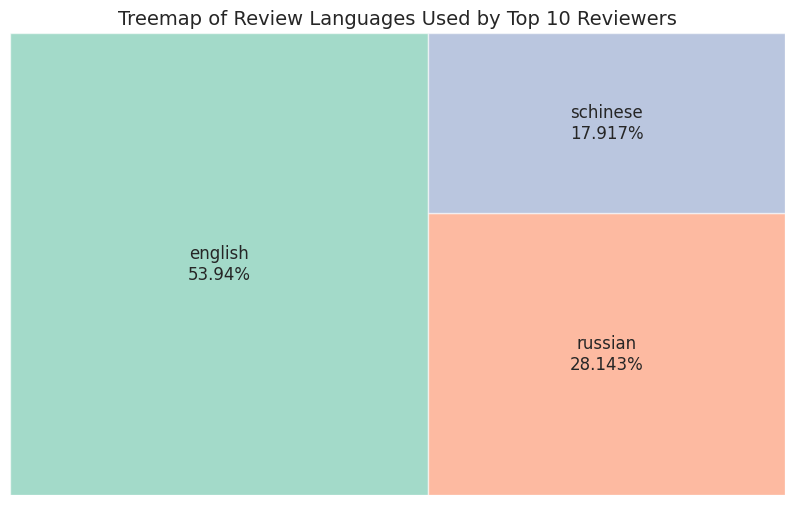

In [40]:
percentages = percentages.str.replace('%', '').astype(float)
sizes = percentages.values

labels = [f"{lang}\n{pct}%" for lang, pct in zip(percentages.index, percentages.values)]

colors = plt.cm.Set2(range(len(sizes)))

# Treemap
plt.figure(figsize=(10, 6))
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.6)
plt.axis('off')
plt.title('Treemap of Review Languages Used by Top 10 Reviewers', fontsize=14)
plt.show()

This graph shows the percentage distribution of languages used by the top 10 reviewers. As we can see, English is the most used language with about 54%, followed by Russian with around 28% and Simplified Chinese around 18%.

/tmp/ipykernel_1016/2184159221.py:13: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(x_indices, helpful_reviews_top_10, linefmt='-b', markerfmt='ob', basefmt=' ', use_line_collection=True)


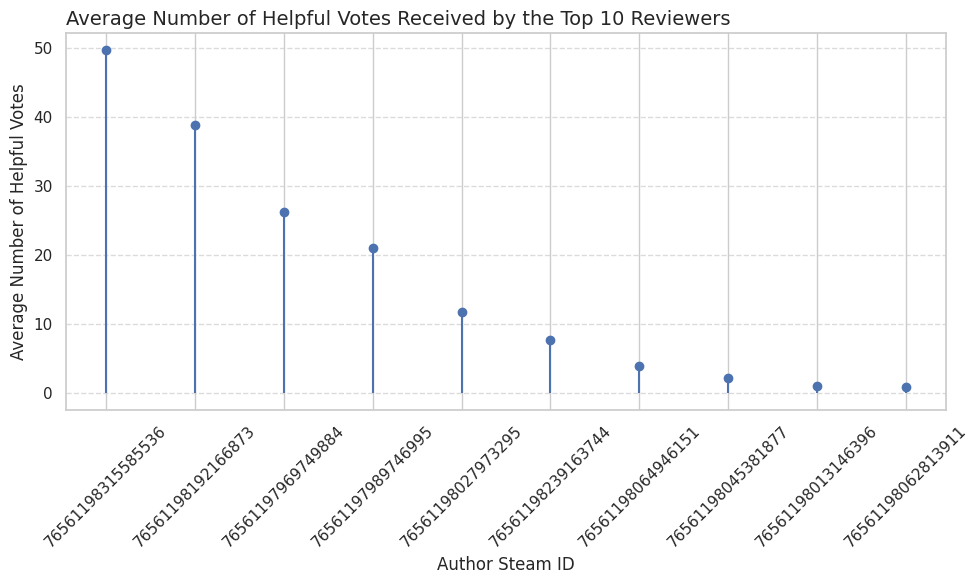

In [41]:
cmap = sns.dark_palette("#69d", reverse=True, as_cmap=True)

# Compute the mean of the helpful votes for each author in top 10
helpful_reviews_mean = df_top_10.groupby('author.steamid').votes_helpful.mean()

# Sort the average helpful votes in descending order and select the top 10
helpful_reviews_top_10 = helpful_reviews_mean.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
x_indices = np.arange(len(helpful_reviews_top_10))

# Lollipop chart
plt.stem(x_indices, helpful_reviews_top_10, linefmt='-b', markerfmt='ob', basefmt=' ', use_line_collection=True)
plt.xticks(x_indices, helpful_reviews_top_10.index, rotation=45)
plt.title('Average Number of Helpful Votes Received by the Top 10 Reviewers', fontsize=14, loc='left')
plt.xlabel('Author Steam ID', fontsize=12)
plt.ylabel('Average Number of Helpful Votes', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


This plot show the number of helpful votes each of the top 10 reviewers received for their reviews. The x-axis list represent the Steam ID of the top 10 reviewers anche the y-axis the nummber of helpful votes each reviewers received. It's important to compare this graph with the number of reviews each one of these reviewers has written, so we can analyze the relationship between the number of reviews written and how many of these were voted helpful. For example the author with the highest number of reviews received the fewest helpful votes among these top reviewers. This suggests that, while this reviewer is highly active, his reviewes are not really helpful to other users, potentially indicating lower-quality or spam-like content. In contrast the author (Steam ID 7656119831558535) who has written 132 reviews, received the highest number of helpful votes. This indicates that his reviews are usually considered helpful. This suggest a a positive impact with the community and reviews written carefully and detailed.

In [42]:
# Check the average of helpful votes for each top 10 reviewer
helpful_reviews_top_10

author.steamid
76561198315585536    49.712121
76561198192166873    38.897196
76561197969749884    26.238636
76561197989746995    21.058140
76561198027973295    11.802083
76561198239163744     7.641509
76561198064946151     3.990000
76561198045381877     2.252427
76561198013146396     0.969697
76561198062813911     0.885906
Name: votes_helpful, dtype: float64

In [65]:
# Group by app_name and count the reviews that each app received
a = df_top_10.groupby('app_name')['review_id'].count()
a = a.sort_values(ascending=False)

palette = px.colors.qualitative.Plotly
unique_values = sorted(a.unique(), reverse=True)
color_map = {freq: palette[i % len(palette)] for i, freq in enumerate(unique_values)}

# Map each frequency in 'a' to its corresponding color
bar_colors = [color_map[val] for val in a]

# Interactive bar chart
fig = go.Figure(data=[go.Bar(
    x=a.index, 
    y=a.values,
    marker_color=bar_colors,
)])
fig.update_layout(
    title="Reviews per App",
    xaxis_title="App",
    yaxis_title="Number of Reviews",
    template="plotly_white",
    xaxis=dict(showticklabels=False)  # This line removes the x-axis tick labels
)

fig.show()

This chart shows all the games reviewed by the top 10 authors and the number of reviews each game received. As we can see, one game stands out with far more reviews than the others: Hollow Knight. This is a popular game among gamers, and a quick search on Google shows that it has over 300,000 reviews on Steam with a 10/10 rating. On the other hand, one of the least reviewed game by the top 10 authors is BERSERK and the Band of the Hawk, which has only around 3,000 reviews. Looking at the main details of these games, there’s also a big price difference: Hollow Knight costs about $7{$}$, while BERSERK and the Band of the Hawk costs $55{$}$. This price difference likely affects the number of reviews each game receives.

# [RQ6]
*Let's investigate the behavior of specific groups, specifically focusing on English and Spanish reviewers*

- Which group is more likely to edit or update their review after submitting it? “English or Spanish!”?
- Provide the average number of games that reviewers from each group have on their Steam accounts and the average number of games for which they write reviews. What can you say about the number you just calculated?

To obtain the two group of reviewers we filter the dataset to contain only English and Spanish reviews.

In [51]:
df_eng = df[df['language'] == 'english']
df_eng.shape

(9635434, 24)

In [52]:
df_span = df[df['language'] == 'spanish']
df_span.shape

(813320, 24)

As observed in the exploratory data analysis (EDA) phase, the number of English reviews surpasses that of Spanish reviews. If we consider the absolute frequency of edited reviews, we anticipate that the English reviews will also be the most numerous.

This trend indicates a stronger engagement or larger player base among English-speaking users, and that the volume of feedback and the likelihood of edits may be more pronounced in the English review category, suggesting that English-speaking players are more active in contributing to and refining their reviews.

In [53]:
number_of_update_eng = (df_eng['timestamp_updated'] != df_eng['timestamp_created']).sum()
print(number_of_update_eng)
number_of_update_span = (df_span['timestamp_updated'] != df_span['timestamp_created']).sum()
print(number_of_update_span)

1146112
80804


To determine whether the trend regarding the number of edited or updated reviews remains consistent when examining percentage frequency, we can calculate the proportion of edited reviews for each language. This involves dividing the number of edited reviews in English and Spanish by the total number of reviews in their respective languages then multiply it by 100.

In [54]:
percentage_edited_eng = round(number_of_update_eng / df_eng.shape[0], 4) * 100
percentage_edited_span = round(number_of_update_span / df_span.shape[0], 4) * 100

In [55]:
print(f'Between the english reviewers the {percentage_edited_eng} % of them edit or update their review')
print(f'Between the spainsh reviewers the {percentage_edited_span} % of them edit or update their review')

Between the english reviewers the 11.89 % of them edit or update their review
Between the spainsh reviewers the 9.94 % of them edit or update their review


As we can see, the difference in the number of edited reviews between English and Spanish is not as pronounced as before, but English reviews still account for the majority. The gap is now only around two percentage points, which indicates that when we consider the percentage frequency to the total number of reviewers in each language group, the behavior between the two groups is not significantly different.
It’s important to note that this small difference may be influenced by the specific time frame we are analyzing. Factors such as game updates, community engagement, or even seasonal trends could affect how often reviews are edited within that particular period. Thus, while the English reviews continue to lead, the percentage frequency suggests a more comparable level of engagement between the two language groups than previously observed.

In [56]:
# Filter the reviews: english and considering the last one
df_reviews_eng_sorted = df_eng.sort_values(by=['author.steamid', 'timestamp_updated'], ascending=[True, False])
latest_reviews_eng = df_reviews_eng_sorted.drop_duplicates(subset=['author.steamid'], keep='first')

# Compute the mean of the games owned
avg_games_owned_eng = round(latest_reviews_eng['author.num_games_owned'].mean(), 3)

print(f"Mean of the games owned by english reviewers: {avg_games_owned_eng}")

# Filter the reviews: spanish and considering the last one
df_reviews_span_sorted = df_span.sort_values(by=['author.steamid', 'timestamp_updated'], ascending=[True, False])
latest_reviews_span = df_reviews_span_sorted.drop_duplicates(subset=['author.steamid'], keep='first')

# Compute the mean of the games owned
avg_games_owned_span = round(latest_reviews_span['author.num_games_owned'].mean(),3)

print(f"Mean of the games owned by spanish reviewers: {avg_games_owned_span}")

Mean of the games owned by english reviewers: 119.631
Mean of the games owned by spanish reviewers: 83.915


This notable difference suggests that English reviewers tend to have a larger game library compared to their Spanish counterparts. This may indicate greater engagement with gaming as a hobby or lifestyle. This could correlate with a more extensive participation in gaming communities, higher likelihood of leaving reviews, and a deeper investment in the gaming ecosystem. The difference in the mean number of games owned may reflect broader trends also in access and cultural factors within the gaming communities of English and Spanish speakers.

In [57]:
reviews_per_eng_author = df_eng.groupby('author.steamid')['app_id'].nunique()
average_games_eng_reviewed = reviews_per_eng_author.mean()
print(f"Average number of unique games reviewed by each English reviewer: {average_games_eng_reviewed}")

reviews_per_span_author = df_span.groupby('author.steamid')['app_id'].nunique()
average_games_span_reviewed = reviews_per_span_author.mean()
print(f"Average number of unique games reviewed by each Spanish reviewer: {average_games_span_reviewed}")

Average number of unique games reviewed by each English reviewer: 1.8118229474081158
Average number of unique games reviewed by each Spanish reviewer: 1.6340314880650075


This indicates that, on average, English reviewers tend to write reviews for a slightly higher number of distinct games compared to their Spanish counterparts.

This trend can be partially explained by the fact that English reviewers typically own more games. However, it's important to note that just owning more games doesn't mean they'll write many reviews. Also, it's known that many gamers, regardless of language, might spend more time playing games than writing reviews. This suggests that the act of reviewing is less about the number of games owned and more about individual engagement levels.

Overall, while the ownership of games may influence the propensity to write reviews, factors such as community engagement, cultural differences, and personal preferences play significant roles in shaping reviewing behavior across different language groups.

# [RQ7]
*Certainly, calculating probabilities and conducting statistical tests are essential skills for any data scientist. Let's calculate some intriguing figures.*

- What is the probability of submitting a review and receiving at least one helpful vote from other users?
- What is the probability of submitting a review and receiving at least one helpful vote from other users, given that you don’t recommend the app?
- Is the probability of “a review receiving at least one helpful vote” independent of the probability that “the reviewer has submitted at least five reviews before the current review”? Elaborate on it.
- We hypothesize that “reviewers who own a larger number of games are likely to leave fewer reviews on the platform.” Please validate or refute this statement through statistical analysis.
- Ask an LLM tool (such as ChatGPT, Claude AI, Gemini, Perplexity, etc.) to understand the purposes of histograms, bar plots, scatterplots, and pie charts and what kind of insights they offer that might be useful for statistical analysis. Are those results trustworthy, or can you do something to improve somehow the confidence in the suggestions given by the LLM?

In [58]:
reviews = df.shape[0]
at_least_one_helpful = df[df['votes_helpful'] > 0].shape[0]
prob_1 = at_least_one_helpful / reviews
print('P(helpful >= 1 | review) = ', prob_1)

P(helpful >= 1 | review) =  0.2807346545202143


The event "submitting a review" is contained in each dataset entry (as each entry is a review itself), so we just need to count the number of rows where there are helpful votes. This method of sampling is the only way we can roughly estimate the probability, as we don't have prior knowledge of the underlying distribution and thus we have to rely on a frequentist interpretation of probability.

In [60]:
df_not_recommended = df[df['recommended'] == False]
at_least_one_helpful = df_not_recommended[df_not_recommended['votes_helpful'] > 0]
prob_2 = at_least_one_helpful.shape[0]/df_not_recommended.shape[0]
print('P(helpful >= 1 | not recommended) = ', prob_2)

P(helpful >= 1 | not recommended) =  0.4846426841263084


Similar to the first question, but we first need to filter just the recommended = False rows, to be able to estimate the conditional probability.

In [61]:
one_helpful = df[df['votes_helpful'] >= 1]
five_reviews = df[df['author.num_reviews'] >= 6]
both_conditions = one_helpful[one_helpful['author.num_reviews'] >= 5]
prob_one_helpful = one_helpful.shape[0] / df.shape[0]
prob_five_reviews = five_reviews.shape[0] / df.shape[0]
prob_both = round(both_conditions.shape[0] / df.shape[0], 3)
prod = round(prob_one_helpful * prob_five_reviews, 3)
print("P(A) = ", prob_one_helpful, " P(B) = ", prob_five_reviews)
print('P(A)*P(B) = ',prod)
print('P(A|B) = ',prob_both)
if prod == prob_both:
  print("The probabilities are independent")
else:
  print("The probabilities are dependent.")

P(A) =  0.2807346545202143  P(B) =  0.3962141160549795
P(A)*P(B) =  0.111
P(A|B) =  0.156
The probabilities are dependent.


Unlike the problem in RQ7.3, we don't need to worry about intermediate review counts by author, thanks to the "before the current review" keyword. We filter the dataset for the rows that have helpful votes, and for authors that have at least 6 reviews (5 before the current one, and the current one).

Seeing as we don't know the underlying distribution of these probabilities, we can estimate the probabilities by sampling, in the frequentist way, as in the other questions, and verify or refute their independence by checking whether P(A)*P(B) = P(A | B).

Via the Law of Large Numbers, if we're observing indicator variables for the events "at least one helpful vote" and "at least five reviews before the current one", as the sample size increases, the frequency in the sample converges to the true value, and the limit of their difference = 0 as sample size goes to infinity. Here, we have a relatively large sample size, but not large enough to be able to look for an exact match in probabilities, so it's wise to round to a certain number of decimals - the most appropriate number of decimals to round to would be the subject of much further analysis.

In this case, we chose to round to 3 decimals, but we can round to up to 1 decimal and still obtain different values, so it's quite safe to say that the variables are not independent.

In [62]:
reviewers = df[['author.steamid', 'author.num_games_owned', 'author.num_reviews']]
reviewers = df.groupby(['author.steamid'])['author.num_reviews'].max()
temp = df.groupby(['author.steamid'])['author.num_games_owned'].max()
df_by_num_reviews_and_num_games = pd.merge(reviewers, temp, left_index = True, right_index = True).sort_values(['author.num_games_owned'], ascending = False)
df_by_num_reviews_and_num_games

print (stats.pearsonr(df_by_num_reviews_and_num_games['author.num_reviews'], df_by_num_reviews_and_num_games['author.num_games_owned']))
print (stats.spearmanr(df_by_num_reviews_and_num_games['author.num_reviews'], df_by_num_reviews_and_num_games['author.num_games_owned']))

PearsonRResult(statistic=0.27846163978609983, pvalue=0.0)
SignificanceResult(statistic=0.500314086900745, pvalue=0.0)


For this, for each author ID, we need to take the row with the highest value in the appropriate columns, as the values in the dataset are those at the time of the review, and not the ones at the time of obtaining the dataset (meaning, if the same author has 10 reviews in the dataset, their author.num_reviews column will have values differing in a range of 10 depending on when each review was published). We're interested in the total review number for each author, and if we're taking every intermediate number we might introduce a lot of noise.

We're first using the Pearson statistical test, which tests for linear correlation, and then the Spearman rank-order correlation, which tests for monotonic (linear or not) relationships. To confirm the hypothesis, we would need to see a negative value approaching -1 for each (the number of reviews decreasing while number of games owned increasing, or vice versa), however, both tests return positive values. The variables are (weakly) positively correlated, so the hypothesis is rejected.

**Question asked to ChatGPT:** In terms of statistical analysis, what is the purpose of histograms, bar plots, scatter plots and pie charts, and what kind of insights can they offer?

**Answer:** Each of these visualization tools serves distinct purposes in statistical analysis and can provide different insights:

1. Histograms
Purpose: Used to represent the distribution of a continuous variable by dividing the data into bins (intervals) and showing the frequency of data points in each bin.
Insights Offered: Histograms help identify the shape of the data distribution (normal, skewed, bimodal), detect outliers, and understand the central tendency and variability of the data.
2. Bar Plots
Purpose: Used for categorical data, bar plots display the frequency or proportion of categories with rectangular bars.
Insights Offered: They make it easy to compare different categories or groups. Bar plots can reveal trends, differences in counts or means across categories, and patterns in categorical data.
3. Scatter Plots
Purpose: Used to show the relationship between two continuous variables, with points representing observations plotted along two axes.
Insights Offered: Scatter plots can reveal correlations (positive, negative, or none), trends, clusters, and potential outliers. They are useful for identifying patterns or associations in bivariate data.
4. Pie Charts
Purpose: Used to represent the proportions of a whole in categorical data, with slices representing each category's contribution to the total.
Insights Offered: Pie charts provide a visual representation of how categories contribute to a whole, making it easy to see relative sizes. However, they can be less effective for comparing similar-sized categories or showing small differences.
Summary
Histograms help understand distributions.
Bar plots are great for comparing categories.
Scatter plots uncover relationships between variables.
Pie charts offer a view of proportions within a whole.
Choosing the right plot depends on the data type and the specific insights you wish to convey.

In general, the answer is correct, but it fails to mention that any insights drawn from visualisations should be paired with appropriate real-world domain knowledge (say, if we observe a sudden drop in stock prices, it's crucial to know the real world effects that may have caused it). Beyond that, visualizations are useful but the way they're presented can change depending on purpose: for example, we may use linear, logarithmic or exponential scales in each axis, or depict just a fraction of the range of values in the distribution, depending on what we want to convey - exaggerating or minimizing some effects. This is useful in marketing (exaggerating interest rates by having a scale from 3 to 3.1%, for example), but can be dangerous in research without proper care.

# Sentiment Analysis

### We will run an example of sentiment analysis on a small subset of the data because we discovered that many reviews are truncated, which would lead to inconsistent results. Additionally, we found that many emojis are present in the reviews. We can use the package demoji to translate the emojis into words before running the sentiment analysis; however, we will not be implementing that in the following sections.

First of all let's run a model that classifies the constructiveness of the review 

We first filter the dataset for the reviews in the top 3 languages (English, Simplified Chinese and Russian), and we also add the review_info column because the constructiveness model (that is trained on Steam reviews beforehand) expects it in this format.

In [48]:
df_test = df.sample(n=20000, random_state=0)

In [93]:
top_3_languages = df_test['language'].value_counts().nlargest(3).index.tolist()
columns_to_use = ['review', 'author.playtime_at_review', 'votes_helpful', 'votes_funny', 'language', 'recommended']
df_senta = df_test[columns_to_use][df_test['language'].isin(top_3_languages)].copy()
df_senta['votes_up'] = df_senta['votes_helpful'].apply(lambda x: True if x > 0 else False)
df_senta['review_info'] = df_senta.apply(
    lambda row: (
        f"Review: {row['review']}, "
        f"Playtime: {row['author.playtime_at_review']}, "
        f"Voted Up: {row['votes_up']}, "
        f"Upvotes: {row['votes_helpful']}, "
        f"Votes Funny: {row['votes_funny']}"
    ),
    axis=1
)

There are some reviews that contain emoji, and there are ways to filter out emoji from strings, such as the code below. However, it was taking very long to execute, so we left it out.

We will drop the rows that are missing text for the reviews because there is nothing to analyze in them - in addition, blank strings would introduce bias in the results.

In [94]:
df_senta = df_senta.dropna(subset=['review'])

In [95]:
df_senta.shape

(14464, 8)

In [96]:
# Set up devices for two GPUs
device0 = torch.device("cuda:0") if torch.cuda.device_count() > 1 else torch.device("cpu")
device1 = torch.device("cuda:1") if torch.cuda.device_count() > 1 else torch.device("cpu")

# Create pipelines for each GPU
classifier_gpu0 = pipeline(
    task="text-classification",
    model="abullard1/albert-v2-steam-review-constructiveness-classifier",
    tokenizer="albert-base-v2",
    device=0,  # Using GPU 0
    max_length=128,
    truncation=True,
    torch_dtype=torch.float16
)

classifier_gpu1 = pipeline(
    task="text-classification",
    model="abullard1/albert-v2-steam-review-constructiveness-classifier",
    tokenizer="albert-base-v2",
    device=1,  # Using GPU 1
    max_length=128,
    truncation=True,
    torch_dtype=torch.float16
)

batch_size = 2048

# Split the DataFrame into two batches
num_batches = (len(df_senta) + batch_size - 1) // batch_size  # Calculate total number of batches
results = []

for batch_index in range(num_batches):
    start = batch_index * batch_size
    end = min((batch_index + 1) * batch_size, len(df_senta))

    # Separate batches for each GPU
    if batch_index % 2 == 0:  # Even index -> GPU 0
        batch_reviews = df_senta["review_info"][start:end].tolist()
        batch_results = classifier_gpu0(batch_reviews)
    else:  # Odd index -> GPU 1
        batch_reviews = df_senta["review_info"][start:end].tolist()
        batch_results = classifier_gpu1(batch_reviews)

    results.extend(batch_results)

# Assign results
df_senta["classification"] = results

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



For each review, we find the argmax that tells us which class is predicted - constructive or not constructive.

In [97]:
# Extract the 'label' value from the classification column
df_senta['classification_max_label'] = df_senta['classification'].apply(
    lambda x: x['label'] if isinstance(x, dict) and 'label' in x else None
)

# Display the updated DataFrame
print(df_senta['classification_max_label'])

18487464    LABEL_0
1436596     LABEL_0
19158104    LABEL_0
15027683    LABEL_0
14257037    LABEL_0
             ...   
1621759     LABEL_0
5895398     LABEL_0
837787      LABEL_0
20913469    LABEL_0
4621976     LABEL_0
Name: classification_max_label, Length: 14464, dtype: object


We are going to consider only the constructive review

In [99]:
df_senta = df_senta[df_senta['classification_max_label'] == 'LABEL_1']

To run the Sentiment Analysis on the English Reviews we'll use the Vader classification model from *NLTK* package

In [100]:
df_eng = df_senta[df_senta['language'] == 'english']

In [101]:
df_eng.shape

(3802, 10)

We define the two thresholds for when we consider a review neutral or positive/negative. The value of this threshold is subject to optimization.

In [102]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def analyze_sentiment_vader(text):
    # Convert NaN values into blank text
    text = str(text) if pd.notnull(text) else None
    
    # Sentiment Analysis
    if text:
        score = sid.polarity_scores(text)['compound']
        if score >= 0.02:
            return 'POSITIVE'
        elif score <= -0.02:
            return 'NEGATIVE'
        else:
            return 'NEUTRAL'
    else:
        return None

# Apply the function on the review column
df_eng['sentiment'] = df_eng['review'].apply(analyze_sentiment_vader)

# Check the distribution of the results
print(df_eng['sentiment'].value_counts())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
sentiment
POSITIVE    3058
NEGATIVE     645
NEUTRAL       99
Name: count, dtype: int64


/tmp/ipykernel_30/1036097784.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [116]:
# Filter and count the values of "sentiment" which correspond to "recommended" values
positive_recommended_count = df_eng[(df_eng["sentiment"] == "POSITIVE") & (df_eng["recommended"] == True)].shape[0]
negative_recommended_count = df_eng[(df_eng["sentiment"] == "NEGATIVE") & (df_eng["recommended"] == True)].shape[0]
neutral_recommended_count = df_eng[(df_eng["sentiment"] == "NEUTRAL") & (df_eng["recommended"] == True)].shape[0]

# Filter and count the values of "sentiment" which NOT correspond to "recommended" values
positive_not_recommended_count = df_eng[(df_eng["sentiment"] == "POSITIVE") & (df_eng["recommended"] == False)].shape[0]
negative_not_recommended_count = df_eng[(df_eng["sentiment"] == "NEGATIVE") & (df_eng["recommended"] == False)].shape[0]
neutral_not_recommended_count = df_eng[(df_eng["sentiment"] == "NEUTRAL") & (df_eng["recommended"] == False)].shape[0]

print("Number of Positive and recommended:", positive_recommended_count)
print("Number of Negative and recommended:", negative_recommended_count)
print("Number of Neutral and recommended:", neutral_recommended_count)
print("Number of Positive and not recommended:", positive_not_recommended_count)
print("Number of Negative and not recommended:", negative_not_recommended_count)
print("Number of Neutral and not recommended:", neutral_not_recommended_count)

Number of Positive and recommended: 2789
Number of Negative and recommended: 353
Number of Neutral and recommended: 76
Number of Positive and not recommended: 269
Number of Negative and not recommended: 292
Number of Neutral and not recommended: 23


At first, we were expecting a high number of negative reviews, because often, people are more likely to leave a review if they have complaints. However, the majority of reviews are positive, and there are more positive reviews than neutral and negative ones combined.

In [103]:
df_rus = df_senta[df_senta['language'] == 'russian']

In [105]:
df_rus.shape

(8, 10)

For the Russian sentiment analysis, we used a RuBERT (Russian BERT) based model. The one used below is the one trained on the largest dataset, with the most downloads from HuggingFace users.

In [106]:
# Set up devices for two GPUs
device0 = torch.device("cuda:0") if torch.cuda.device_count() > 1 else torch.device("cpu")
device1 = torch.device("cuda:1") if torch.cuda.device_count() > 1 else torch.device("cpu")

# Create pipelines for each GPU
model_name = 'blanchefort/rubert-base-cased-sentiment'

classifier_gpu0 = pipeline(
    task="text-classification",
    model=model_name,
    tokenizer=model_name,
    device=0,  # Using GPU 0
    top_k=None,
    truncation=True,
    max_length=128,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
)

classifier_gpu1 = pipeline(
    task="text-classification",
    model=model_name,
    tokenizer=model_name,
    device=1,  # Using GPU 1
    top_k=None,
    truncation=True,
    max_length=128,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
)

# Define a function to classify each review in a batch
def classify_reviews_batch(reviews, classifier):
    results = classifier(reviews)
    # Extract the top label for each result
    return [max(result, key=lambda x: x['score'])['label'] for result in results]

batch_size = 2048
results = []

num_batches = (len(df_rus) + batch_size - 1) // batch_size  # Calculate total number of batches

for batch_index in range(num_batches):
    start = batch_index * batch_size
    end = min((batch_index + 1) * batch_size, len(df_rus))
    batch_reviews = df_rus["review"][start:end].tolist()
    
    # Alternate between GPUs
    if batch_index % 2 == 0:  # Even index -> GPU 0
        batch_results = classify_reviews_batch(batch_reviews, classifier_gpu0)
    else:  # Odd index -> GPU 1
        batch_results = classify_reviews_batch(batch_reviews, classifier_gpu1)

    results.extend(batch_results)

# Assign results
df_rus["sentiment"] = results

# Print the results
print(df_rus["sentiment"].value_counts())

sentiment
NEUTRAL     4
NEGATIVE    3
POSITIVE    1
Name: count, dtype: int64


In [107]:
# Filter and count the values of "sentiment" which correspond to "recommended" values
positive_recommended_count = df_rus[(df_rus["sentiment"] == "POSITIVE") & (df_rus["recommended"] == True)].shape[0]
negative_recommended_count = df_rus[(df_rus["sentiment"] == "NEGATIVE") & (df_rus["recommended"] == True)].shape[0]
neutral_recommended_count = df_rus[(df_rus["sentiment"] == "NEUTRAL") & (df_rus["recommended"] == True)].shape[0]

# Filter and count the values of "sentiment" which NOT correspond to "recommended" values
positive_not_recommended_count = df_rus[(df_rus["sentiment"] == "POSITIVE") & (df_rus["recommended"] == False)].shape[0]
negative_not_recommended_count = df_rus[(df_rus["sentiment"] == "NEGATIVE") & (df_rus["recommended"] == False)].shape[0]
neutral_not_recommended_count = df_rus[(df_rus["sentiment"] == "NEUTRAL") & (df_rus["recommended"] == False)].shape[0]

print("Number of Positive and recommended:", positive_recommended_count)
print("Number of Negative and recommended:", negative_recommended_count)
print("Number of Neutral and recommended:", neutral_recommended_count)
print("Number of Positive and not recommended:", positive_not_recommended_count)
print("Number of Negative and not recommended:", negative_not_recommended_count)
print("Number of Neutral and not recommended:", neutral_not_recommended_count)

Number of Positive and recommended: 0
Number of Negative and recommended: 1
Number of Neutral and recommended: 3
Number of Positive and not recommended: 1
Number of Negative and not recommended: 2
Number of Neutral and not recommended: 1


In [108]:
df_sch = df_senta[df_senta['language'] == 'schinese']

In [110]:
df_sch.shape

(22, 10)

In [111]:
# Set up devices for two GPUs
device0 = torch.device("cuda:0") if torch.cuda.device_count() > 0 else torch.device("cpu")
device1 = torch.device("cuda:1") if torch.cuda.device_count() > 1 else torch.device("cpu")

# Set the model and tokenizer for sentiment analysis
model_name = 'uer/roberta-base-finetuned-jd-binary-chinese'

# Create pipeline for each GPU
classifier_gpu0 = pipeline(
    task="sentiment-analysis",
    model=model_name,
    tokenizer=model_name,
    device=0 if device0.type == "cuda" else -1,
    max_length=512,
    truncation=True,
    torch_dtype=torch.float16 if device0.type == "cuda" else torch.float32
)

classifier_gpu1 = pipeline(
    task="sentiment-analysis",
    model=model_name,
    tokenizer=model_name,
    device=1 if device1.type == "cuda" else -1,
    max_length=512,
    truncation=True,
    torch_dtype=torch.float16 if device1.type == "cuda" else torch.float32
)

# Define thresholds
threshold_positive = 0.45
threshold_negative = 0.45

# Custom function to classify sentiment based on thresholds
def classify_reviews_batch(batch, classifier):
    results = classifier(batch)
    sentiments = []

    for result in results:
        # Check if result is a list of dictionaries or a single dictionary
        if isinstance(result, list):
            scores = {item['label']: item['score'] for item in result}
        elif isinstance(result, dict):  # Handle single dictionary case
            scores = {result['label']: result['score']}
        else:
            print(f"Unexpected result format: {result}")
            continue

        # Classify sentiment based on thresholds
        if scores.get('positive (stars 4 and 5)', 0) >= threshold_positive:
            sentiments.append('POSITIVE')
        elif scores.get('negative (stars 1, 2 and 3)', 0) >= threshold_negative:
            sentiments.append('NEGATIVE')
        else:
            sentiments.append('NEUTRAL')

    return sentiments

# Set batch size
batch_size = 2048
num_batches = (len(df_sch) + batch_size - 1) // batch_size  # Calculate total number of batches
sentiments = []

# Process data in batches and distribute between GPUs
for batch_index in range(num_batches):
    start = batch_index * batch_size
    end = min((batch_index + 1) * batch_size, len(df_sch))
    batch_reviews = df_sch["review"][start:end].tolist()
    
    # Alternate between GPU0 and GPU1
    if batch_index % 2 == 0:
        batch_sentiments = classify_reviews_batch(batch_reviews, classifier_gpu0)
    else:
        batch_sentiments = classify_reviews_batch(batch_reviews, classifier_gpu1)
    
    sentiments.extend(batch_sentiments)

# Assign the sentiment results to the DataFrame
df_sch["sentiment"] = sentiments

# Display sentiment counts
print(df_sch["sentiment"].value_counts())


sentiment
POSITIVE    13
NEGATIVE     9
Name: count, dtype: int64


In [113]:
# Filter and count the values of "sentiment" which correspond to "recommended" values
positive_recommended_count = df_sch[(df_sch["sentiment"] == "POSITIVE") & (df_sch["recommended"] == True)].shape[0]
negative_recommended_count = df_sch[(df_sch["sentiment"] == "NEGATIVE") & (df_sch["recommended"] == True)].shape[0]

# Filter and count the values of "sentiment" which NOT correspond to "recommended" values
positive_not_recommended_count = df_sch[(df_sch["sentiment"] == "POSITIVE") & (df_sch["recommended"] == False)].shape[0]
negative_not_recommended_count = df_sch[(df_sch["sentiment"] == "NEGATIVE") & (df_sch["recommended"] == False)].shape[0]

print("Number of Positive and recommended:", positive_recommended_count)
print("Number of Negative and recommended:", negative_recommended_count)
print("Number of Positive and not recommended:", positive_not_recommended_count)
print("Number of Negative and not recommended:", negative_not_recommended_count)

Number of Positive and recommended: 9
Number of Negative and recommended: 2
Number of Positive and not recommended: 4
Number of Negative and not recommended: 7


Pearson Correlation: -0.05413599854451544
Spearman Correlation: -0.08924511113608971


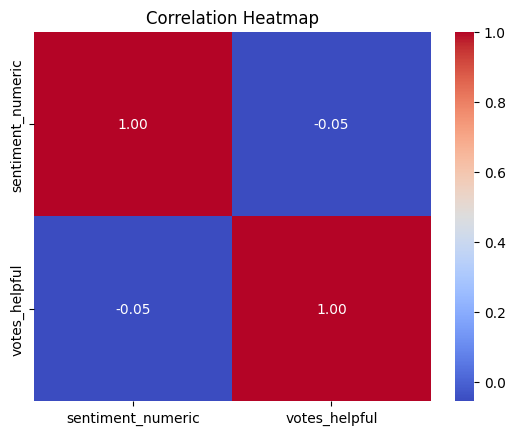

In [114]:
from scipy.stats import spearmanr, pearsonr

df_final = pd.concat([df_eng, df_rus, df_sch], ignore_index=True)
# Convert sentiment to numerical values
sentiment_mapping = {'POSITIVE': 1, 'NEUTRAL': 0, 'NEGATIVE': -1}
df_final['sentiment_numeric'] = df_final['sentiment'].map(sentiment_mapping)

# Calculate Pearson and Spearman correlations
pearson_corr, _ = pearsonr(df_final['sentiment_numeric'], df_final['votes_helpful'])
spearman_corr, _ = spearmanr(df_final['sentiment_numeric'], df_final['votes_helpful'])

print(f"Pearson Correlation: {pearson_corr}")
print(f"Spearman Correlation: {spearman_corr}")

import plotly.express as px

# Example scatter plot
fig = px.scatter(df_final, x='votes_helpful', y='sentiment',
                 title='Scatter Plot of Helpfulness Votes vs. Sentiments',
                 labels={'votes_helpful': 'Number of Helpfulness Votes',
                         'sentiment': 'Sentiment'},
                 opacity=0.5)

# Show the plot
fig.show()

# Visualize correlation heatmap
correlation_matrix = df_final[['sentiment_numeric', 'votes_helpful']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


# Algorithmic Question (AQ)
For this algorithm, for given input numbers n and k, we need to find whether it's possible to represent n as a sum of k numbers, with each having the same parity. Since it doesn't matter whether they are all even or all odd, as long as the parity is the same, either answer is valid. A detail that vastly simplifies the complexity (both mathematical and logic-wise) of the problem is that the k numbers do not need to be unique, and the values can repeat an arbitrary number of times as long as they are all positive.

The given algorithm works on the basis of constructing two lists of numbers that are potential solutions - one is filled with 2s, the other with 1s, and both are of length k-1. Subtracting the sum of these lists from n gives us a potential final number of the list for both cases - the k_even solution, or the k_odd solution.

If the final number obtained from the k_even solution is also even (like the 2s in the list), we still need to check if it's greater than 0 (at least 2), so as to fulfil the requirements of the problem. If it is smaller than 0, because the rest of the list is comprised of 2s, we cannot subtract i*2 from any other number in the list to add it to the final number, since then the number subtracted from would become 0 or negative. Thus, a solution in this case would be impossible. However, if the last number is greated than 0, the solution is valid. This produces solutions of the form [2, 2, 2,.....,j * 2].

The same logic follows for the k_odd solution. If all the condition checks pass, we obtain a solution of the form [1, 1, 1,......., j]

Most of the solvable test cases have a vast number of solutions, and this algorithm returns the one where where the first k-1 numbers are "minimized" (either all 1s or all 2s) and the last number is "maximized". However, because of the k[i] > 0 restriction, we can obtain any other solution from this "base" solution.

Namely, since numbers maintain parity when adding or subtracting 2 (or a multiple or 2), we can construct a different valid solution by subtracting a multiple of 2 from one member of the list (so long as it's still positive afterwards) and add it to another. Through this, while [2, 2, 2, 94] is a valid solution for n=100, k=4, so is [2, 2, 4, 92], [4, 8, 16, 72] etc. All other valid solutions for a certain parity can be obtained by "transferring" multiples of 2 around.

This logic is reversible, as well, and any even or odd solution can be transformed into [2, 2, 2,...., j*2] and [1, 1, 1,....,j] respectively, therefore, for any n, if a solution exists, there is always at least the solution of this form, and potentially other ones. Given this, we can say that the algorithm is complete.

Given this code, the code's complexity is linear per each test case, due to the construction of the potential number lists - which takes k steps per test case, giving a O(k) complexity overall. Evaluating all test cases takes quadratic time, or O(n^2), because there are nested for loops.

ChatGPT's answer on evaluating time complexity is that it's O(T*k), meaning O(k) per test case (T), where k is is the maximum across the test cases. The assessment is accurate, it just uses different notation.

There are some optimizations that can be made to the best-case complexity of the algorithm (for example, only trying the k_odd solution if n < 2k), but they would not impact the big O complexity.

In [ ]:
test_cases = int(input())
for case in range(test_cases):
  n, k = map(int, input().split())
  k_even, k_odd = list(), list()
  for i in range(k-1):
    k_even.append(2)
    k_odd.append(1)
  last_1 = n - 2*(k-1)
  last_2 = n - (k-1)
  if last_1%2 == 0 and last_1 > 0:
    k_even.append(last_1)
    print("YES")
    print(*k_even)
    continue
  elif last_2%2 == 1 and last_2 > 0:
    k_odd.append(last_2)
    print("YES")
    print(*k_odd)
    continue
  else:
    print("NO")
    continue